An overview of boosting tree algorithms, their main differences, performance comparisons, and hyperparameter optimization. In this notebook, we will delve deeper into boosted trees, specifically comparing XGBoost, CatBoost, and LightGBM. We will explore their main differences, parameters in each algorithm, compare their performance on different datasets, assess their CPU and GPU usage, conduct Optuna optimization, and examine SHAP values.

- [This Notebook repository](https://github.com/joaomh/xgboost-catboost-lgbm)
- [Undergraduate GitHub repository](https://github.com/joaomh/study_boosting_optuna_USP_undergraduate_thesis)
- [Link to my Undergraduate thesis in PT-BR](https://bdta.abcd.usp.br/item/003122385)


# Tables of Content:

**1. [Introduction](#Introduction)**

**2. [Ensemble Learning](#Ensemble)**

**3. [AdaBoost](#Ada)** 

**4. [GBMs](#GBM)** 

**5. [XGBoost vs. CatBoost vs. LightGBM](#XGBoost)** 
- 5.1 [Tree Symmetry](#Tree)
- 5.2 [Splitting Method](Splitting)

**6. [Models Performance CPU vs GPU](#Models)** 

**7. [Optuna in XGBoost vs. CatBoost vs. LightGBM](#Optuna)** 

**8. [Shap in XGBoost vs. CatBoost vs. LightGBM](#Shap)** 

**9. [Conclusions](#Conclusion)**

**10. [Bibliography](#Bibliography)**


# Introduction

The purpose of this post is to introduce the fundamentals of boosting algorithms and the main difference between XGBoost, CatBoost and LightGBM. We will give the reader some necessary keys to well understand and use related methods and be able to design adapted solutions when needed.

If we look at the [2022 Kaggle Data Science & ML Survey](https://www.kaggle.com/kaggle-survey-2022), we can see that Gradient Boosting Machines (GBMs) have been widely used in recent years. They are supervised machine learning algorithms that have consistently produced excellent results across a wide range of problems and have won numerous machine learning competitions.


![png1](./img/kaggle_state.png)

They achieve this because boosting algorithms are very effective on tabular datasets and offer the same performance as other state-of-the-art deep learning techniques, but they are easier to implement and cost less in terms of computer resources.

# Ensemble 
Many machine learning models primarily aim for high prediction accuracy using a single model, where boosting algorithms strive to enhance predictions by sequentially training a series of weak models, with each model compensating for the weaknesses of its predecessors.

First of all we need to understand Ensemble Learning, it's based on the idea of combining several simpler prediction models (weak learner), training them for the same task, and producing from them a more complex grouped model (strong learner) that is the sum of its parts.

For example, when creating an ensemble model based on several decision trees, which are simple yet high-variance models (often considered 'weak learners'), we need to aggregate them to enhance their resistance to data variations. Therefore, it makes sense to train the trees separately, allowing each one to adapt to different parts of the dataset. This way, each tree gains knowledge about various data variations, collectively improving the ensemble's predictive performance.

There are various ensemble learning methods, but in this text, we will primarily focus on Boosting, which is used in GBMs, but we can mention three algorithms that aims at combining weak learners:

**Bagging**: It is generally done with homogeneous predictors, each one operating independently in relation to the others, in a parallel manner. The final algorithm is then constructed by aggregating the results obtained from the base models in some form of average. Random Forest is one of the most famous algorithm.

**Boosting**: Generally implemented with homogeneous predictors, applied sequentially where the posterior model depends on the predecessor, and then these models are combined in the final ensemble. GBMs work like this

**Stacking**: It is typically done with heterogeneous predictors, training them in parallel, and then combining their outputs by training a meta-model that generates predictions based on the predictions of the various weak models. Here we can for combine RandomForest with DecisionTree for example.

![png1](./img/boosting_bagging.png) [Image from Ensemble Learning: Bagging & Boosting](https://towardsdatascience.com/ensemble-learning-bagging-boosting-3098079e5422)

# AdaBoost
AdaBoost is a specific Boosting algorithm developed for classification problems hte original AdaBoost algorithm is designed for classification problems, where the output is either −1 or 1, and the final prediction for a given instance is a weighted sum of each generated weak classifier

$$
G(x) = sign\bigr[\sum^M_{m=1}\alpha_m\cdot G_m(x)\bigr]
$$
Here, the weights $\alpha_m$
are computed by the boosting algorithm, and the idea is to increase the influence of weak learners that are more accurate while simultaneously penalizing those that are not.
The weakness is identified by the weak estimator error rate
$$err_m = \frac{\sum_{i=1}^Nw_i\mathbf{I}(y_i\neq G_m(x_i))}{\sum_{i=1}^Nw_i}$$


1. Initialize the observation weights $w_i = 1/N, i = 1, 2, . . . , N .$
2. For $m=1$ to $M$:

    2.1. Fit a classifier $G_m(x)$ to the training data using weights $w_i$

    2.2. Compute $err_m = \frac{\sum_{i=1}^Nw_i\mathbf{1}(y_i\neq G_m(x_i))}{\sum_{i=1}^Nw_i}$

    2.3. Compute $\alpha_m = log((1-err_m)/err_m)$

    2.4. Set $w_i \rightarrow w_i\cdot exp[\alpha_m \cdot \mathbf{1}(y_i\neq G_m(x_i))],i=1,2,...,N$

3. Output $G(x) = sign\bigr[\sum^M_{m=1}\alpha_m\cdot G_m(x)\bigr]$

From [1][2]

![png](img/ada.png) [Marsh, Brendan (2016). Multivariate Analysis of the Vector Boson Fusion Higgs Boson](https://www.researchgate.net/publication/306054843_Multivariate_Analysis_of_the_Vector_Boson_Fusion_Higgs_Boson)

Scikit-Learn have a implementation of AdaBoost

In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
clf.predict([[0, 0, 0, 0]])
clf.score(X, y)

0.983

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an AdaBoostClassifier with a base DecisionTreeClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
clf.score(X, y)

0.96

# GBMs
The Gradient Boosting Machines algorithm works by optimizing any given differentiable loss function, using gradient descent [3].

We can write de GBM model as 

$$F_M(x) = F_0(x) + \sum_{m=1}^MF_m(x)$$
$ \beta_mh(x; a_m)$ are the base functions learners, where $\beta_m$ is the weight, and $a_m$ the parameters of the learner $h$. And we have a loss function $L(y_i,F_m(x_i))$, so we would like to find all optimal values of this parameters that would minimize this loss funciton.
$$    \{\beta_m,\alpha_m\}_1^M = {\arg\min}_{\{\beta'_m,\alpha'_m\}_1^M}\sum_{i=1}^n L\Biggl(y^{(i)},\sum_{m=1}^M\beta'_mh(\mathbf{x}^{(i)};\alpha'_m)\Biggl)$$

In this situations where is infeasible we can try a 'greedy-stagewise' approach for $m=1,2,3,...,M$

$$(\beta_m,\alpha_m) = {\arg\min}_{\beta,\alpha}\sum_{i=1}^n L\Biggl(y^{(i)},F_{m-1}\mathbf{x}^{(i)} + \beta h(\mathbf{x}^{(i)};\alpha)\Biggl)$$
And then we can use a vectorized notation and make similar to the gradient descent formula. The learning rate, $\eta$ shrinks the influence of the new learner.
$$F_m(\mathbf{X}) = F_{m-1}(\mathbf{X}) + \eta \Delta_m(X)$$


The gradient of the loss function $L$ with relation to the last estimate $F_{m−1}(x)$ is,
$$-g_m(\mathbf{x}^{(i)}) = -\Bigg[\frac{\partial L(y^{(i)},c^{(i)})}{\partial F(\mathbf{x}^{(i)})}\Bigg]$$


Gradient of the loss function $L$ with respect to the last prediction is sometimes called pseudo-residual, and written as $r_{m−1}$ can be written as
$$\mathbf{r}_{m_1} = \nabla F_{m-1}(\mathbf{X})L(y,F_{m-1}(\mathbf{X})) = \nabla \hat{y}_{m-1}L(y,\hat{y}_{\mathbf{m-1}})$$


1. $F_0(\mathbf{X} = \arg\min_v\sum_{i=1}^n L(y^{(i)},v)$
2. For $m=1$ to $M$:

    2.1. $\mathbf{r}_{m_1} = \nabla \hat{y}_{m-1}L(y,\hat{y}_{\mathbf{m-1}})$ # Train a base learner minimizing squared error

    2.2. $\alpha = {\arg\min}_{\alpha,\beta}\sum_{i=1}^n(\mathbf{r}_{m-1}^{(i)}-\beta h(\mathbf{x}^{(i)};\alpha))^2$

    2.3. $\beta = {\arg\min}_{\beta}\sum_{i=1}^nL(y^{(i)},F_{m-1}(\mathbf{x}^{(i))}+\beta h(\mathbf{x}^{(i))};\alpha_m)$

    2.4. $\Delta_m(X) = \beta_mh(\mathbf{X};\alpha_m)$
    
    2.5 $F_m(\mathbf{X}) = F_{m-1}(\mathbf{X}) + \eta \Delta_m(X)$                                                              

3. Output $F_m$

From [3]


As you can see, it is an iterative algorithm that usually works with decision trees. We train a sequence of decision trees to gradually reduce the training error (each new tree tries to predict the residual error, this is the error at that current iteration and then we multiplied by the learning rate

![boost](img/boosting_tree.png)

As you can see the final prediction is:

initial_prediction + learning_rate*residual_0 + learning_rate*residual_1 _+ ... learning_rate*residual_N

Or

$F_m(\mathbf{X}) = F_{m-1}(\mathbf{X}) + \eta \Delta_m(X)$ 



We also can find Gradient Boosting function in scikit-learn

In [3]:
import pandas as pd
import numpy as np 
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
X = pd.DataFrame(load_breast_cancer()['data'],columns=load_breast_cancer()['feature_names'])
y = pd.DataFrame(load_breast_cancer()['target'],columns=['target'])
kf = KFold(n_splits=5,random_state=42,shuffle=True)
for train_index, index in kf.split(X):
    X_train,X_val = X.iloc[train_index],X.iloc[index],
    y_train,y_val = y.iloc[train_index],y.iloc[index],
gradient_booster = GradientBoostingClassifier()
gradient_booster.fit(X_train,y_train.values.ravel())
print(classification_report(y_val,gradient_booster.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        46
           1       0.96      0.99      0.97        67

    accuracy                           0.96       113
   macro avg       0.97      0.96      0.96       113
weighted avg       0.96      0.96      0.96       113



# XGBoost vs. CatBoost vs. LightGBM

XGBoost, Catboost, and LightGBM are all variations of gradient boosting algorithms, each employing decision trees as weak learners. I strongly recommend reading the papers [4], [5], [6]. Now, I'm going to highlight the main differences in each algorithm.

|   | XGBoost  | CatBoost  | LightGBM  |
|---|---|---|---|
|Developer |DMLC| Yandex| Microsoft|
|Release Year |2014 |2017 |2016|
|Tree Symmetry |Asymmetric: Level-wise tree growth |Symmetric |Asymmetric: Leaf-wise tree growth|
|Splitting Method |Pre-sorted and histogram-based algorithms |Greedy| GOSS|
|Categorical Columns |Support but must use numerical columns, cannot interpret ordinal category| Support |Support|
|Text Columns | Not Support| Support: Bag-of-Words, Naive-Bayes or BM25 to calculate numerical features from text| Not Support| 
|Missing Values | Handle | Handle |Handle|
|Training on|CPU and GPU|CPU and GPU|CPU and GPU|
|Others things| Works with Spark | Easy generate the Learning Curve |Have a RandomForest "boosting method"|

All of the models have different loss functions in their objectives, some of which are as follows:

For Regression:

* L2: mean squared error (default, recovers the mean value)
* L1: mean absolute error (good for outliers)
* MAPE: mean absolute percentage error (good for time series)
* Quantile: predict quantiles
* Poisson

For Classification:
* Logloss for binary classification
* Multiclass and cross-entropy for multi-class problems

For other loss functions, you can refer to the documentation of all three algorithms.


# Tree Symmetry
||||
|---|---|---|
![](https://github.com/joaomh/study_boosting_optuna_USP_undergraduate_thesis/blob/main/LaTeX-overleaf/images/CatBoost.png?raw=true)|![](https://github.com/joaomh/study_boosting_optuna_USP_undergraduate_thesis/blob/main/LaTeX-overleaf/images/XGboost.png?raw=true)|![](https://github.com/joaomh/study_boosting_optuna_USP_undergraduate_thesis/blob/main/LaTeX-overleaf/images/LGBM.png?raw=true)

CatBoost produces symmetric trees (or balanced trees). This refers to the splitting condition across all the nodes at the same depth. On the other hand, XGBoost and LightGBM produce asymmetric trees, meaning that the splitting condition at each node can be different.

Another important thing to note is that LightGBM grows leaf-wise (horizontally), while XGBoost grows level-wise (vertically). The picture below can show in more detail the differences in these growth types. This approach can lead to deeper trees with fewer nodes, potentially making it faster to train but may require more memory.

![](https://www.researchgate.net/publication/353155099/figure/fig2/AS:1044071766310913@1625937515739/Level-wise-vs-leaf-wise-tree-growth.png)

# Splitting Method
This determines how the splitting is determined in each algorithm.

In XGBoost, the pre-sorted algorithm considers all features and sorts them by value. The histogram algorithm groups feature values into discrete bins and finds the split point based on these bins. However, it is slower than GOSS.

CatBoost uses a greedy method where a list of possible candidates for feature splits is assigned to the leaf, and the split that results in the smallest penalty is selected.

In LightGBM, Gradient-based One-Side Sampling (GOSS) retains all the data with large gradients and performs random sampling for data instances with small gradients (small traning error). This results in fewer data instances used to train the model.

# Prevent Overfitting

All of the tree models come equipped with excellent parameters designed to mitigate overfitting. We will utilize many of these parameters in our Optuna hyperparameter optimization, some of them are:

**early_stopping_rounds:** This parameter employs an integer to halt the learning process. It identifies a point at which the validation score no longer improves, and in some cases, it may even start to deteriorate, while the training score continues to improve. This is not a hyperparameter that we intend to tune, but it's a crucial parameter to use, and it's not active by default.

**reg_alpha or lambda_l1:** These parameters represent the coefficient at the L1 regularization term of the cost function.

**reg_lambda or l2_leaf_reg:** These parameters represent the coefficient at the L2 regularization term of the cost function.

**learning_rate:** This setting is used to control the gradient step size and, in turn, affects the overall training time. Smaller values require more iterations for training.

**depth or max_depth:** This parameter limits the maximum depth of the tree model. It is employed to combat overfitting when dealing with small datasets.

**num_leaves or max_leaves:** The maximum number of leafs in the resulting tree

**random_strength:** This parameter determines the amount of randomness applied when scoring splits during the selection of the tree structure. You can adjust this parameter to mitigate the risk of overfitting in your model.

# Hyperparameter Tuning
As you can see all three libraries offer a variety of hyperparameters to tune, and their effectiveness can vary depending on the dataset. We will use Optuna in ours tests

# Models Performance CPU vs GPU

In this section, we are going to use three different datasets: epsilon, higgs, and breast cancer. However, we will not delve deeply into the typical steps of a data science project, such as EDA (Exploratory Data Analysis), pre-processing, handling missing values, plotting some variables, and analyzing correlations. Our primary focus will be the performance of out-of-the-box models, as they are designed to handle certain aspects by default, such as missing values.

## Epsilon
[Epsilon dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#epsilon).
This dataset is best suited for binary classification.

The training dataset contains 400000 objects. Each object is described by 2001 columns. The first column contains the label value, all other columns contain numerical features.

The validation dataset contains 100000 objects. The structure is identical to the training dataset.


In [4]:
from catboost.datasets import epsilon
epsilon_train, epsilon_test = epsilon()

In [5]:
epsilon_train.shape, epsilon_test.shape

((400000, 2001), (100000, 2001))

In [6]:
# convert target -1 to 0
epsilon_train[epsilon_train[0] <= 0] = 0
epsilon_test[epsilon_test[0] <= 0] = 0

In [7]:
X_train = epsilon_train.loc[:,1:]
X_test = epsilon_test.loc[:,1:]
y_train = epsilon_train.loc[:,0]
y_test = epsilon_test.loc[:,0]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400000, 2000), (100000, 2000), (400000,), (100000,))

In [8]:
import timeit
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
time_cpu = ['CPU']
results_auc_cpu = []
models = [XGBClassifier(),
          CatBoostClassifier(verbose=False),
          LGBMClassifier(verbose=-1)]
for i in range(len(models)):
    start = timeit.default_timer()
    model_ = models[i].fit(X_train, y_train)
    stop = timeit.default_timer()
    time_cpu.append(stop-start)
    y_prob = model_.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    results_auc_cpu.append(metrics.auc(fpr, tpr))

In [10]:
time_cpu

['CPU', 100.57174560100248, 173.5943495399988, 29.465143476001685]

In [11]:
results_auc_cpu

[1.0, 1.0, 1.0]

In [12]:
models = [XGBClassifier(tree_method='gpu_hist'),
          CatBoostClassifier(verbose=False,task_type="GPU"),
          LGBMClassifier(verbose=-1,device='gpu')]

time_gpu = ['GPU']
results_auc_gpu = []
for i in range(len(models)):
    start = timeit.default_timer()
    model_ = models[i].fit(X_train, y_train)
    stop = timeit.default_timer()
    time_gpu.append(stop-start)
    y_prob = model_.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    results_auc_gpu.append(metrics.auc(fpr, tpr))

In [13]:
time_gpu

['GPU', 8.82751414100494, 18.60794683700078, 13.281327325996244]

In [14]:
results_auc_gpu

[1.0, 1.0, 1.0]

## Higgs

[Higgs](https://archive.ics.uci.edu/dataset/280/higgs)
This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not. 

The training dataset contains 10500000 objects. Each object is described by 29 columns. The first column contains the label value, all other columns contain numerical features.

The validation dataset contains 5000000 objects. The structure is identical to the training dataset.
Method call format

In [15]:
from catboost.datasets import higgs
higgs_train, higgs_test = higgs()

In [16]:
higgs_train.shape, higgs_test.shape

((10500000, 29), (500000, 29))

In [17]:
X_train = higgs_train.loc[:,1:]
X_test = higgs_test.loc[:,1:]
y_train = higgs_train.loc[:,0]
y_test = higgs_test.loc[:,0]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10500000, 28), (500000, 28), (10500000,), (500000,))

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
time_cpu = ['CPU']
results_auc_cpu = []
models = [XGBClassifier(),
          CatBoostClassifier(verbose=False),
          LGBMClassifier(verbose=-1)]
for i in range(len(models)):
    start = timeit.default_timer()
    model_ = models[i].fit(X_train, y_train)
    stop = timeit.default_timer()
    time_cpu.append(stop-start)
    y_prob = model_.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    results_auc_cpu.append(metrics.auc(fpr, tpr))

In [19]:
time_cpu

['CPU', 208.93801863700355, 304.1608348700029, 30.22637001700059]

In [20]:
results_auc_cpu

[0.823429407021503, 0.8412804649425808, 0.8118326628507959]

In [21]:
models = [XGBClassifier(tree_method='gpu_hist'),
          CatBoostClassifier(verbose=False,task_type="GPU"),
          LGBMClassifier(verbose=-1,device='gpu')]

time_gpu = ['GPU']
results_auc_gpu = []
for i in range(len(models)):
    start = timeit.default_timer()
    model_ = models[i].fit(X_train, y_train)
    stop = timeit.default_timer()
    time_gpu.append(stop-start)
    y_prob = model_.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    results_auc_gpu.append(metrics.auc(fpr, tpr))

In [22]:
time_gpu

['GPU', 5.500959073993727, 43.70296749100089, 14.413947692002694]

In [23]:
results_auc_gpu

[0.8237744245413271, 0.8105542884220551, 0.8118326588372813]

## Breast Cancer

[Breast Cancer](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) 

The breast cancer dataset is a classic and very easy binary classification dataset.

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image

In [24]:
from sklearn.datasets import load_breast_cancer
breast_cancer =  load_breast_cancer(as_frame=True).frame

In [25]:
from sklearn.model_selection import train_test_split
X = breast_cancer.drop(columns=['target'])
y = breast_cancer.loc[:,'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
time_cpu = ['CPU']
results_auc_cpu = []
models = [XGBClassifier(),
          CatBoostClassifier(verbose=False),
          LGBMClassifier(verbose=-1)]
for i in range(len(models)):
    start = timeit.default_timer()
    model_ = models[i].fit(X_train, y_train)
    stop = timeit.default_timer()
    time_cpu.append(stop-start)
    y_prob = model_.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    results_auc_cpu.append(metrics.auc(fpr, tpr))

In [27]:
time_cpu

['CPU', 0.016339898997102864, 0.9324936460034223, 0.02608547400450334]

In [28]:
results_auc_cpu

[0.9947089947089948, 0.9972075249853027, 0.9944150499706055]

In [29]:
models = [XGBClassifier(tree_method='gpu_hist'),
          CatBoostClassifier(verbose=False,task_type="GPU"),
          LGBMClassifier(verbose=-1,device='gpu')]

time_gpu = ['GPU']
results_auc_gpu = []
for i in range(len(models)):
    start = timeit.default_timer()
    model_ = models[i].fit(X_train, y_train)
    stop = timeit.default_timer()
    time_gpu.append(stop-start)
    y_prob = model_.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    results_auc_gpu.append(metrics.auc(fpr, tpr))

In [30]:
time_gpu

['GPU', 0.0601679419996799, 17.182826510994346, 0.45593334099976346]

In [31]:
results_auc_gpu

[0.9938271604938271, 0.9977954144620811, 0.9952968841857731]

# Optuna

Now, let's attempt to utilize Optuna with the three algorithms, applying it to our largest dataset. We will employ early_stopping to determine the optimal number of iterations that minimizes the validation loss, and we'll also consider class weights using the 'balanced' option.

Another valuable aspect to explore is the use of sample weights, which can be passed as an array of shape n_samples. This feature proves exceptionally useful in applications such as churn modeling, where we aim to prevent the churn of high-value customers with greater profitability.

Here, we have a function that calculates numerous classification metrics. While our primary optimization focus will be on AUC, feel free to make adjustments as needed.

In [32]:
import sys
import timeit
import gc
from sklearn import metrics
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lightgbm
from lightgbm import LGBMClassifier

def metrics_validation(y_test, y_prob):
    '''
    Input:
        y_prob: model predict prob
        y_test: target
    Output: Metrics of validation
        auc, ks, log_loss, accuracy
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    auc = metrics.auc(fpr, tpr)
    log_loss = metrics.log_loss(y_test, y_prob)
    ks = max(tpr - fpr) # Kolmogorov-Smirnov
    accu = metrics.accuracy_score(y_test, y_prob.round())
    precision = metrics.precision_score(y_test, y_prob.round()) # tp / (tp + fp)
    recall = metrics.recall_score(y_test, y_prob.round()) # tp / (tp + fn)
    f1_score = metrics.f1_score(y_test, y_prob.round()) # 2 * (precision * recall) / (precision + recall)
    return auc, log_loss, ks, 

Creating our objective function and the set of hyperparameter space."

In [33]:
def objective(trial, X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        trial: trial of the test
        X_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or None
        method: XGBoost, CatBoost or LGBM
    Output: Metrics of validation
        auc, ks, log_loss
        metrics_validation(y_test, y_pred)[0]
    '''
    gc.collect()
    if method=='LGBM':
        param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
                      'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                      'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                      'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
                      'max_depth': trial.suggest_int('max_depth', 5, 64),
                      'feature_fraction': trial.suggest_float("feature_fraction", 0.4, 1.0),
                      'bagging_fraction': trial.suggest_float("bagging_fraction", 0.4, 1.0),
                      'device':'gpu',
                      'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
  
                     }
        model = LGBMClassifier(**param_grid)

        print('LGBM - Optimization using optuna')
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_test)[:,1]

    if method=='CATBoost':
        param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
                      'depth': trial.suggest_int("depth", 4, 10),
                      'max_bin': trial.suggest_int('max_bin', 200, 400),
                      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
                      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10, log = True),
                      'random_seed': 42,
                      'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
                      'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
                      'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
                      'task_type':'GPU',
                      'od_wait': trial.suggest_int("od_wait", 10, 50),
                     }
        if len(X_train._get_numeric_data().columns) != len(X_train.columns):
            categorical_features_indices = list(X_train.select_dtypes(exclude='number').columns)
            model = CatBoostClassifier(**param_grid)
            print('CATBoost - Optimization using optuna')
            model.fit(X_train, y_train,cat_features=categorical_features_indices,verbose=False)
            y_pred = model.predict_proba(X_test)[:,1]
        else:
            model = CatBoostClassifier(**param_grid)
            print('CATBoost - Optimization using optuna')
            model.fit(X_train, y_train,verbose=False)
            y_pred = model.predict_proba(X_test)[:,1]
        
    if method=='XGBoost':
        param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
                      'max_depth': trial.suggest_int('max_depth', 3, 16),
                      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
                      'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log = True),
                      'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log = True),
                      'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
                      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
                      'booster': 'gbtree',
                      'tree_method':'gpu_hist',
                      'random_state': 42,
                     }
        model = XGBClassifier(**param_grid)
        print('XGBoost - Optimization using optuna')
        model.fit(X_train, y_train,verbose=False)
        y_pred = model.predict_proba(X_test)[:,1]
    
    auc_res, log_loss_res, ks_res = metrics_validation(y_test, y_pred)
    print('auc:'+str(auc_res),', log_loss:'+str(log_loss_res),', ks:'+str(ks_res))
    return metrics_validation(y_test, y_pred)[0]

Tuning the model: Here, the study will be created, and an important aspect to note is the **time_max_tuning,** which represents the maximum time in seconds to stop.

In [34]:
def tuning(X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        trial: 
        x_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or not balanced
        method: XGBoost, CatBoost or LGBM
    Output: Metrics of validation
        auc, ks, log_loss
        metrics_validation(y_test, y_pred)[0]
    '''
    study = optuna.create_study(direction='maximize', study_name=method+' Classifier')
    func = lambda trial: objective(trial, X_train, y_train, X_test, y_test, balanced, method)
    print('Starting the optimization')
    time_max_tuning = 15*60 # max time in seconds to stop
    study.optimize(func, timeout=time_max_tuning)
    return study

Train the model while implementing **early_stopping**, and then return the best model.

In [35]:
def train(X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        X_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or None
        method: XGBoost, CatBoost or LGBM
    Output: predict model
    '''
    print('Tuning')
    study = tuning(X_train, y_train, X_test, y_test, balanced, method)
    if method=='LGBM':
        model = LGBMClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                 callbacks = [lightgbm.early_stopping(stopping_rounds=100), lightgbm.log_evaluation(period=5000)])
    if method=='CATBoost':
        model = CatBoostClassifier(**study.best_params)
        if len(X_train._get_numeric_data().columns) != len(X_train.columns):
            categorical_features_indices = list(X_train.select_dtypes(exclude='number').columns)
            print('Last Fit')
            model.fit(X_train, y_train,cat_features=categorical_features_indices, eval_set=[(X_test,y_test)],
                 early_stopping_rounds=100,verbose = False)
        else:
            print('Last Fit')
            model.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                 early_stopping_rounds=100,verbose = False)
    if method=='XGBoost':
        model = XGBClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                 early_stopping_rounds=100,verbose = False)
    return model, study

In [39]:
X_train = higgs_train.loc[:,1:]
X_test = higgs_test.loc[:,1:]
y_train = higgs_train.loc[:,0]
y_test = higgs_test.loc[:,0]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10500000, 28), (500000, 28), (10500000,), (500000,))

In [40]:
xgb_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='XGBoost')

[I 2023-10-03 20:05:05,770] A new study created in memory with name: XGBoost Classifier


Tuning
Starting the optimization
XGBoost - Optimization using optuna
auc:0.8160714188768703 , log_loss:0.5625867343804195 , ks:0.4707839553090411


[I 2023-10-03 20:05:20,998] Trial 0 finished with value: 0.8160714188768703 and parameters: {'learning_rate': 0.014461545107824847, 'max_depth': 13, 'min_child_weight': 274, 'gamma': 2.685092337834412e-08, 'alpha': 1.1303389978159601e-07, 'lambda': 0.0037974543642193773, 'colsample_bytree': 0.6187173763615156}. Best is trial 0 with value: 0.8160714188768703.


XGBoost - Optimization using optuna
auc:0.8153558675013712 , log_loss:0.5980449019664544 , ks:0.46919683522486755


[I 2023-10-03 20:05:42,969] Trial 1 finished with value: 0.8153558675013712 and parameters: {'learning_rate': 0.007681017817452525, 'max_depth': 16, 'min_child_weight': 295, 'gamma': 8.394136809835826e-06, 'alpha': 0.003830783555808915, 'lambda': 0.15494646707295295, 'colsample_bytree': 0.6265576194235859}. Best is trial 0 with value: 0.8160714188768703.


XGBoost - Optimization using optuna
auc:0.7938849907336838 , log_loss:0.6113386502777107 , ks:0.4334986301351884


[I 2023-10-03 20:05:51,481] Trial 2 finished with value: 0.7938849907336838 and parameters: {'learning_rate': 0.008642243937655893, 'max_depth': 8, 'min_child_weight': 134, 'gamma': 4.1214485228999705e-06, 'alpha': 0.0005882209195223604, 'lambda': 0.01697940444276006, 'colsample_bytree': 0.6066976345148787}. Best is trial 0 with value: 0.8160714188768703.


XGBoost - Optimization using optuna
auc:0.7467487261159675 , log_loss:0.6877180454090693 , ks:0.3483088410334263


[I 2023-10-03 20:06:00,285] Trial 3 finished with value: 0.7467487261159675 and parameters: {'learning_rate': 0.0012140580389851234, 'max_depth': 9, 'min_child_weight': 220, 'gamma': 0.007691216354457009, 'alpha': 0.017236316640416617, 'lambda': 0.18429008447079587, 'colsample_bytree': 0.1621613744128354}. Best is trial 0 with value: 0.8160714188768703.


XGBoost - Optimization using optuna
auc:0.7804428359503353 , log_loss:0.5774324575490736 , ks:0.4120434360389573


[I 2023-10-03 20:06:07,785] Trial 4 finished with value: 0.7804428359503353 and parameters: {'learning_rate': 0.07902268379119089, 'max_depth': 6, 'min_child_weight': 151, 'gamma': 3.291161666220187e-05, 'alpha': 0.0007906911106314722, 'lambda': 0.08547673061198874, 'colsample_bytree': 0.14393036959687783}. Best is trial 0 with value: 0.8160714188768703.


XGBoost - Optimization using optuna
auc:0.8300751185214701 , log_loss:0.5104441660925311 , ks:0.4943815105642797


[I 2023-10-03 20:06:25,492] Trial 5 finished with value: 0.8300751185214701 and parameters: {'learning_rate': 0.04207326516562167, 'max_depth': 14, 'min_child_weight': 206, 'gamma': 0.23915275217081786, 'alpha': 3.42501035517271e-05, 'lambda': 0.0008752778409159388, 'colsample_bytree': 0.6353446241287046}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.7555655064809303 , log_loss:0.6293524463911325 , ks:0.37167288190764924


[I 2023-10-03 20:06:32,455] Trial 6 finished with value: 0.7555655064809303 and parameters: {'learning_rate': 0.021127747930971028, 'max_depth': 4, 'min_child_weight': 173, 'gamma': 1.0982563314753644e-07, 'alpha': 0.00047626984396553714, 'lambda': 5.967401560632587, 'colsample_bytree': 0.1918286245277176}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.8128424852380012 , log_loss:0.5289524105335889 , ks:0.46462075583510687


[I 2023-10-03 20:06:40,428] Trial 7 finished with value: 0.8128424852380012 and parameters: {'learning_rate': 0.0882004116100355, 'max_depth': 7, 'min_child_weight': 227, 'gamma': 0.00043391407363144294, 'alpha': 0.0012841735071229276, 'lambda': 0.0006427765301135334, 'colsample_bytree': 0.4022483495730823}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.8115527451622996 , log_loss:0.6899830979435947 , ks:0.46312382036897887


[I 2023-10-03 20:07:02,013] Trial 8 finished with value: 0.8115527451622996 and parameters: {'learning_rate': 0.00015725114878258745, 'max_depth': 15, 'min_child_weight': 223, 'gamma': 0.022357240819363494, 'alpha': 3.5454406429174326e-06, 'lambda': 0.6808598495750001, 'colsample_bytree': 0.6903488439580941}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.7507034211259309 , log_loss:0.684510335928647 , ks:0.3557299952980999


[I 2023-10-03 20:07:15,793] Trial 9 finished with value: 0.7507034211259309 and parameters: {'learning_rate': 0.0019099902517487357, 'max_depth': 13, 'min_child_weight': 200, 'gamma': 1.8574016312275589e-06, 'alpha': 7.180654535705901e-07, 'lambda': 2.660799376418031, 'colsample_bytree': 0.1580239286703511}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.8269488861834312 , log_loss:0.5147160846070759 , ks:0.48878500760248683


[I 2023-10-03 20:07:29,976] Trial 10 finished with value: 0.8269488861834312 and parameters: {'learning_rate': 0.03426850381023882, 'max_depth': 12, 'min_child_weight': 44, 'gamma': 0.35920347885614134, 'alpha': 0.18124311183875305, 'lambda': 0.00013391943007198513, 'colsample_bytree': 0.7889404702437497}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.8267554179036014 , log_loss:0.5155184243151416 , ks:0.48830970392074247


[I 2023-10-03 20:07:44,520] Trial 11 finished with value: 0.8267554179036014 and parameters: {'learning_rate': 0.033941278047400665, 'max_depth': 12, 'min_child_weight': 34, 'gamma': 0.862598239200619, 'alpha': 0.282464158753137, 'lambda': 0.00010671711749449273, 'colsample_bytree': 0.7824657726970117}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.8247159992496187 , log_loss:0.51643433244236 , ks:0.48511200506515945


[I 2023-10-03 20:07:56,175] Trial 12 finished with value: 0.8247159992496187 and parameters: {'learning_rate': 0.038435694813742594, 'max_depth': 11, 'min_child_weight': 82, 'gamma': 0.9919992886356024, 'alpha': 4.978921563516134e-05, 'lambda': 0.00015377384010625052, 'colsample_bytree': 0.7747395823027643}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.807395368777724 , log_loss:0.6383809404352234 , ks:0.4560813426905799


[I 2023-10-03 20:08:22,556] Trial 13 finished with value: 0.807395368777724 and parameters: {'learning_rate': 0.004455091270875308, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.07753560545576478, 'alpha': 0.2927093523502968, 'lambda': 0.0013814805092376061, 'colsample_bytree': 0.4985722490253711}. Best is trial 5 with value: 0.8300751185214701.


XGBoost - Optimization using optuna
auc:0.8348732943572185 , log_loss:0.4983926444139988 , ks:0.5024701807772184


[I 2023-10-03 20:08:33,384] Trial 14 finished with value: 0.8348732943572185 and parameters: {'learning_rate': 0.09899748497778434, 'max_depth': 11, 'min_child_weight': 98, 'gamma': 0.0011833043961143774, 'alpha': 5.75006710814136e-06, 'lambda': 0.0005062069960528658, 'colsample_bytree': 0.7742353497909675}. Best is trial 14 with value: 0.8348732943572185.


XGBoost - Optimization using optuna
auc:0.8296678022582782 , log_loss:0.5055922040486227 , ks:0.4931835784608611


[I 2023-10-03 20:08:43,157] Trial 15 finished with value: 0.8296678022582782 and parameters: {'learning_rate': 0.08645887965570928, 'max_depth': 10, 'min_child_weight': 110, 'gamma': 0.0009581163320040558, 'alpha': 1.9931505032909023e-05, 'lambda': 0.007845832772446992, 'colsample_bytree': 0.7006621738399037}. Best is trial 14 with value: 0.8348732943572185.


XGBoost - Optimization using optuna
auc:0.841081579959363 , log_loss:0.4908186691084899 , ks:0.513601429292245


[I 2023-10-03 20:09:11,686] Trial 16 finished with value: 0.841081579959363 and parameters: {'learning_rate': 0.08921349613796856, 'max_depth': 16, 'min_child_weight': 78, 'gamma': 0.0036337908223430058, 'alpha': 4.655321463659426e-08, 'lambda': 0.0009864554893157808, 'colsample_bytree': 0.546510040348285}. Best is trial 16 with value: 0.841081579959363.


XGBoost - Optimization using optuna
auc:0.8212203037251145 , log_loss:0.5531837096706446 , ks:0.47923540685698895


[I 2023-10-03 20:09:44,660] Trial 17 finished with value: 0.8212203037251145 and parameters: {'learning_rate': 0.01814183382870006, 'max_depth': 16, 'min_child_weight': 88, 'gamma': 0.003048073242836511, 'alpha': 1.1582894013237326e-08, 'lambda': 0.0032849468820511105, 'colsample_bytree': 0.5295635802161318}. Best is trial 16 with value: 0.841081579959363.


XGBoost - Optimization using optuna
auc:0.7946943430242 , log_loss:0.5503888560112872 , ks:0.43504198342166556


[I 2023-10-03 20:09:51,744] Trial 18 finished with value: 0.7946943430242 and parameters: {'learning_rate': 0.09067577257245396, 'max_depth': 4, 'min_child_weight': 55, 'gamma': 0.0002697962751130612, 'alpha': 5.616558471222911e-07, 'lambda': 0.021132779438296983, 'colsample_bytree': 0.39589707893306925}. Best is trial 16 with value: 0.841081579959363.


XGBoost - Optimization using optuna
auc:0.8192893302650791 , log_loss:0.5260668098090886 , ks:0.4753993618912427


[I 2023-10-03 20:10:01,729] Trial 19 finished with value: 0.8192893302650791 and parameters: {'learning_rate': 0.0449551626143986, 'max_depth': 10, 'min_child_weight': 108, 'gamma': 0.002407356996708773, 'alpha': 2.5143753058983084e-08, 'lambda': 0.00039543781542807766, 'colsample_bytree': 0.5180995226405741}. Best is trial 16 with value: 0.841081579959363.


XGBoost - Optimization using optuna
auc:0.7868023924472163 , log_loss:0.5854798951388688 , ks:0.42285373325511316


[I 2023-10-03 20:10:09,578] Trial 20 finished with value: 0.7868023924472163 and parameters: {'learning_rate': 0.01535480423898924, 'max_depth': 6, 'min_child_weight': 75, 'gamma': 0.017641022343366855, 'alpha': 5.431667589393069e-06, 'lambda': 0.002372181785429472, 'colsample_bytree': 0.7240071636359782}. Best is trial 16 with value: 0.841081579959363.


XGBoost - Optimization using optuna
auc:0.8345951757346247 , log_loss:0.5011366900391527 , ks:0.5025440698842241


[I 2023-10-03 20:10:27,380] Trial 21 finished with value: 0.8345951757346247 and parameters: {'learning_rate': 0.05508878231823042, 'max_depth': 14, 'min_child_weight': 164, 'gamma': 0.07004725594085451, 'alpha': 7.813171246719482e-05, 'lambda': 0.0007242110957958136, 'colsample_bytree': 0.6712958192670682}. Best is trial 16 with value: 0.841081579959363.


XGBoost - Optimization using optuna
auc:0.8355624399940259 , log_loss:0.4994882992205644 , ks:0.5032259471987823


[I 2023-10-03 20:10:45,981] Trial 22 finished with value: 0.8355624399940259 and parameters: {'learning_rate': 0.05588926464091546, 'max_depth': 14, 'min_child_weight': 138, 'gamma': 0.05413089794144421, 'alpha': 9.607976874346931e-05, 'lambda': 0.0003716326824091521, 'colsample_bytree': 0.704800549786828}. Best is trial 16 with value: 0.841081579959363.


XGBoost - Optimization using optuna
auc:0.8437951609576797 , log_loss:0.4862388045339353 , ks:0.5185781456623907


[I 2023-10-03 20:11:08,770] Trial 23 finished with value: 0.8437951609576797 and parameters: {'learning_rate': 0.09497201157768914, 'max_depth': 16, 'min_child_weight': 123, 'gamma': 0.0044338139693267655, 'alpha': 1.8619255252326368e-07, 'lambda': 0.0003144628784949497, 'colsample_bytree': 0.7377209265117873}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8277555874914296 , log_loss:0.524245424967302 , ks:0.4904860232814635


[I 2023-10-03 20:11:36,696] Trial 24 finished with value: 0.8277555874914296 and parameters: {'learning_rate': 0.028035295703563574, 'max_depth': 16, 'min_child_weight': 130, 'gamma': 0.008822745609528046, 'alpha': 7.394823931994126e-08, 'lambda': 0.0003241199893105179, 'colsample_bytree': 0.5738514819897372}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8362507260323515 , log_loss:0.49896721050401893 , ks:0.5048391765754392


[I 2023-10-03 20:11:59,552] Trial 25 finished with value: 0.8362507260323515 and parameters: {'learning_rate': 0.052029419878423605, 'max_depth': 15, 'min_child_weight': 131, 'gamma': 0.046903075920458795, 'alpha': 4.086368411353952e-07, 'lambda': 0.00026173688700517644, 'colsample_bytree': 0.6929999918032677}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8354045666110691 , log_loss:0.5002619939891819 , ks:0.5037062547859211


[I 2023-10-03 20:12:20,587] Trial 26 finished with value: 0.8354045666110691 and parameters: {'learning_rate': 0.04881963322245883, 'max_depth': 15, 'min_child_weight': 180, 'gamma': 0.00013451529215974953, 'alpha': 2.221634726890195e-07, 'lambda': 0.0018535604446634545, 'colsample_bytree': 0.7377712072961995}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8296750402303308 , log_loss:0.5243480647264323 , ks:0.4937725280646985


[I 2023-10-03 20:12:55,586] Trial 27 finished with value: 0.8296750402303308 and parameters: {'learning_rate': 0.023450014691101233, 'max_depth': 15, 'min_child_weight': 15, 'gamma': 0.0041807831270313876, 'alpha': 2.778760840297035e-08, 'lambda': 0.006396794472405355, 'colsample_bytree': 0.6658626157362915}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8380913936260681 , log_loss:0.49676205706739834 , ks:0.5088441805642505


[I 2023-10-03 20:13:28,255] Trial 28 finished with value: 0.8380913936260681 and parameters: {'learning_rate': 0.06401353645227335, 'max_depth': 16, 'min_child_weight': 65, 'gamma': 0.0008017540440025777, 'alpha': 1.0145262808292539e-08, 'lambda': 0.0002418229982296365, 'colsample_bytree': 0.5688996763714436}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8155392458137708 , log_loss:0.5748900907080784 , ks:0.46950343782409704


[I 2023-10-03 20:13:45,911] Trial 29 finished with value: 0.8155392458137708 and parameters: {'learning_rate': 0.012331314407154391, 'max_depth': 13, 'min_child_weight': 61, 'gamma': 0.0006944946015017054, 'alpha': 5.880509936145105e-08, 'lambda': 0.0012486381059796455, 'colsample_bytree': 0.5722211185726259}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8203483975922488 , log_loss:0.5453873995692241 , ks:0.47791499908351937


[I 2023-10-03 20:14:20,497] Trial 30 finished with value: 0.8203483975922488 and parameters: {'learning_rate': 0.0248491316440079, 'max_depth': 16, 'min_child_weight': 68, 'gamma': 6.130786323121797e-05, 'alpha': 1.1459303908890328e-07, 'lambda': 0.00010386994594953587, 'colsample_bytree': 0.44618878729785105}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8368309556417983 , log_loss:0.49797000845522194 , ks:0.5060570103005693


[I 2023-10-03 20:14:43,477] Trial 31 finished with value: 0.8368309556417983 and parameters: {'learning_rate': 0.05617584586564126, 'max_depth': 15, 'min_child_weight': 118, 'gamma': 0.013636631704884746, 'alpha': 1.3855950306812755e-08, 'lambda': 0.00028671108195212194, 'colsample_bytree': 0.6596974188736147}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8394532407601746 , log_loss:0.4933799589323397 , ks:0.5111635880743685


[I 2023-10-03 20:15:09,016] Trial 32 finished with value: 0.8394532407601746 and parameters: {'learning_rate': 0.07051349466936445, 'max_depth': 16, 'min_child_weight': 118, 'gamma': 0.0015107301084465211, 'alpha': 1.543808764248837e-08, 'lambda': 0.00020161901738371163, 'colsample_bytree': 0.6193713901534377}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8389392011489186 , log_loss:0.4948564939216765 , ks:0.5097257326654914


[I 2023-10-03 20:15:38,440] Trial 33 finished with value: 0.8389392011489186 and parameters: {'learning_rate': 0.061813228495635184, 'max_depth': 16, 'min_child_weight': 87, 'gamma': 0.0018365841719359972, 'alpha': 1.0644036467305274e-08, 'lambda': 0.00020588934179092679, 'colsample_bytree': 0.6085167278196283}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8398163707973506 , log_loss:0.4930770751438815 , ks:0.5113548028059409


[I 2023-10-03 20:16:07,559] Trial 34 finished with value: 0.8398163707973506 and parameters: {'learning_rate': 0.06807193753019014, 'max_depth': 16, 'min_child_weight': 85, 'gamma': 0.0031516850210672655, 'alpha': 4.3957076738170174e-08, 'lambda': 0.000953346584060577, 'colsample_bytree': 0.6204733167625288}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8393267864691167 , log_loss:0.492594512976342 , ks:0.5105790690212978


[I 2023-10-03 20:16:25,359] Trial 35 finished with value: 0.8393267864691167 and parameters: {'learning_rate': 0.09609601809800641, 'max_depth': 14, 'min_child_weight': 153, 'gamma': 0.006624890515326736, 'alpha': 4.23417903549067e-08, 'lambda': 0.000854916747206879, 'colsample_bytree': 0.6328389375815254}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8145412131334413 , log_loss:0.5754486253822075 , ks:0.46824043851119646


[I 2023-10-03 20:16:40,645] Trial 36 finished with value: 0.8145412131334413 and parameters: {'learning_rate': 0.011668150946076771, 'max_depth': 13, 'min_child_weight': 261, 'gamma': 0.0002308175289958974, 'alpha': 1.4677716336655917e-07, 'lambda': 0.003829271806610327, 'colsample_bytree': 0.6206088684449657}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8361272221400203 , log_loss:0.5043469352175065 , ks:0.5045910847084016


[I 2023-10-03 20:17:22,797] Trial 37 finished with value: 0.8361272221400203 and parameters: {'learning_rate': 0.03338287506511206, 'max_depth': 16, 'min_child_weight': 32, 'gamma': 0.003503821044097761, 'alpha': 5.033779465475108e-08, 'lambda': 0.0013231474547645778, 'colsample_bytree': 0.7386381122591315}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8395861823435595 , log_loss:0.4929807342420942 , ks:0.5112349654918908


[I 2023-10-03 20:17:45,675] Trial 38 finished with value: 0.8395861823435595 and parameters: {'learning_rate': 0.07075989159228173, 'max_depth': 15, 'min_child_weight': 96, 'gamma': 0.00029187990326473215, 'alpha': 2.0977273362359827e-07, 'lambda': 0.0004410728548415116, 'colsample_bytree': 0.6468150117449458}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.7546632405671292 , log_loss:0.6078950462737623 , ks:0.37070014827952286


[I 2023-10-03 20:17:52,438] Trial 39 finished with value: 0.7546632405671292 and parameters: {'learning_rate': 0.019916459566994088, 'max_depth': 3, 'min_child_weight': 94, 'gamma': 3.807547334634517e-05, 'alpha': 8.25403229741425e-07, 'lambda': 0.0005932196982494759, 'colsample_bytree': 0.656138330187656}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.822734190823606 , log_loss:0.5736543714993934 , ks:0.4824884238384642


[I 2023-10-03 20:18:24,224] Trial 40 finished with value: 0.822734190823606 and parameters: {'learning_rate': 0.009605958959864106, 'max_depth': 15, 'min_child_weight': 46, 'gamma': 0.00036429715525641495, 'alpha': 2.688419853433531e-07, 'lambda': 0.0009639813664457431, 'colsample_bytree': 0.7414441463631781}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.838768188137564 , log_loss:0.4946759601297103 , ks:0.5097426198006768


[I 2023-10-03 20:18:51,464] Trial 41 finished with value: 0.838768188137564 and parameters: {'learning_rate': 0.07164026326747948, 'max_depth': 16, 'min_child_weight': 118, 'gamma': 0.0018954812670204325, 'alpha': 8.048244750334538e-08, 'lambda': 0.0004887615487388981, 'colsample_bytree': 0.5956790206845969}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8390591585553495 , log_loss:0.4938115666943799 , ks:0.5106062693315092


[I 2023-10-03 20:19:14,101] Trial 42 finished with value: 0.8390591585553495 and parameters: {'learning_rate': 0.07293027990931196, 'max_depth': 15, 'min_child_weight': 102, 'gamma': 0.007516203481590497, 'alpha': 1.472036915044351e-06, 'lambda': 0.002073980879334011, 'colsample_bytree': 0.6146619615288362}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8306003283536388 , log_loss:0.5103205170413102 , ks:0.4949050471863336


[I 2023-10-03 20:19:33,243] Trial 43 finished with value: 0.8306003283536388 and parameters: {'learning_rate': 0.03854030634468477, 'max_depth': 14, 'min_child_weight': 145, 'gamma': 0.0005534458854174783, 'alpha': 1.4137647934046905e-07, 'lambda': 0.00018556563201329573, 'colsample_bytree': 0.6443469739629962}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8298870656045141 , log_loss:0.5159773327175937 , ks:0.4943102053258021


[I 2023-10-03 20:19:57,820] Trial 44 finished with value: 0.8298870656045141 and parameters: {'learning_rate': 0.029369995505718813, 'max_depth': 15, 'min_child_weight': 122, 'gamma': 0.00011645685212829624, 'alpha': 2.895555841314201e-08, 'lambda': 0.00016004738945300706, 'colsample_bytree': 0.6862767411245192}. Best is trial 23 with value: 0.8437951609576797.


XGBoost - Optimization using optuna
auc:0.8218929892084903 , log_loss:0.5157104767014798 , ks:0.47980592298271957


[I 2023-10-03 20:20:05,992] Trial 45 finished with value: 0.8218929892084903 and parameters: {'learning_rate': 0.0991634518192262, 'max_depth': 8, 'min_child_weight': 77, 'gamma': 0.001434919413584937, 'alpha': 2.022739842777901e-07, 'lambda': 0.0006757258170851214, 'colsample_bytree': 0.5503067519251236}. Best is trial 23 with value: 0.8437951609576797.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Last Fit


In [41]:
cat_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='CATBoost')

[I 2023-10-03 20:25:33,961] A new study created in memory with name: CATBoost Classifier


Tuning
Starting the optimization
CATBoost - Optimization using optuna
auc:0.8184044789907015 , log_loss:0.5186560281425432 , ks:0.47468363713191714


[I 2023-10-03 20:26:11,014] Trial 0 finished with value: 0.8184044789907015 and parameters: {'learning_rate': 0.09881147237133969, 'depth': 4, 'max_bin': 363, 'min_data_in_leaf': 128, 'l2_leaf_reg': 0.0967564055013353, 'random_strength': 1.3435757129920417e-07, 'bagging_temperature': 1.2282505630800344, 'od_type': 'Iter', 'od_wait': 41}. Best is trial 0 with value: 0.8184044789907015.


CATBoost - Optimization using optuna
auc:0.8077792426003866 , log_loss:0.5317363369635333 , ks:0.45704309028600115


[I 2023-10-03 20:26:47,883] Trial 1 finished with value: 0.8077792426003866 and parameters: {'learning_rate': 0.08721932266884756, 'depth': 4, 'max_bin': 396, 'min_data_in_leaf': 99, 'l2_leaf_reg': 1.7480208647791937e-05, 'random_strength': 1.289825711325993e-08, 'bagging_temperature': 4.988040132613492, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 0 with value: 0.8184044789907015.


CATBoost - Optimization using optuna
auc:0.7826555959758404 , log_loss:0.5707871548210812 , ks:0.41381266929548904


[I 2023-10-03 20:27:52,233] Trial 2 finished with value: 0.7826555959758404 and parameters: {'learning_rate': 0.002318103560367547, 'depth': 8, 'max_bin': 345, 'min_data_in_leaf': 130, 'l2_leaf_reg': 0.036488695050512984, 'random_strength': 8.797844219187943e-05, 'bagging_temperature': 2.15412667157018, 'od_type': 'Iter', 'od_wait': 21}. Best is trial 0 with value: 0.8184044789907015.


CATBoost - Optimization using optuna
auc:0.7401159538737 , log_loss:0.6702690317990748 , ks:0.3549582785598514


[I 2023-10-03 20:28:36,560] Trial 3 finished with value: 0.7401159538737 and parameters: {'learning_rate': 0.00015906826959464655, 'depth': 6, 'max_bin': 280, 'min_data_in_leaf': 254, 'l2_leaf_reg': 0.9217402553933354, 'random_strength': 0.17197899663503266, 'bagging_temperature': 6.352413859190499, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 0 with value: 0.8184044789907015.


CATBoost - Optimization using optuna
auc:0.7517622482683387 , log_loss:0.6138134782607829 , ks:0.3674374984137297


[I 2023-10-03 20:29:19,252] Trial 4 finished with value: 0.7517622482683387 and parameters: {'learning_rate': 0.0009668177012360596, 'depth': 6, 'max_bin': 258, 'min_data_in_leaf': 272, 'l2_leaf_reg': 0.02110496181405126, 'random_strength': 0.0023246868726508993, 'bagging_temperature': 2.643325961840125, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 0 with value: 0.8184044789907015.


CATBoost - Optimization using optuna
auc:0.7911978386962534 , log_loss:0.5542985251431273 , ks:0.43025249048740677


[I 2023-10-03 20:30:06,682] Trial 5 finished with value: 0.7911978386962534 and parameters: {'learning_rate': 0.020324466941775286, 'depth': 6, 'max_bin': 290, 'min_data_in_leaf': 102, 'l2_leaf_reg': 6.831369723024497e-07, 'random_strength': 2.1888406948210392e-08, 'bagging_temperature': 8.123295370201, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 0 with value: 0.8184044789907015.


CATBoost - Optimization using optuna
auc:0.7596471056327108 , log_loss:0.6330755737165927 , ks:0.37431491812488915


[I 2023-10-03 20:31:14,846] Trial 6 finished with value: 0.7596471056327108 and parameters: {'learning_rate': 0.0004160291133784667, 'depth': 9, 'max_bin': 330, 'min_data_in_leaf': 105, 'l2_leaf_reg': 0.00021078912330344245, 'random_strength': 1.184445075203689e-06, 'bagging_temperature': 5.346868984736332, 'od_type': 'Iter', 'od_wait': 37}. Best is trial 0 with value: 0.8184044789907015.


CATBoost - Optimization using optuna
auc:0.8235217745820589 , log_loss:0.5127387967639394 , ks:0.4823989072618805


[I 2023-10-03 20:32:11,572] Trial 7 finished with value: 0.8235217745820589 and parameters: {'learning_rate': 0.03733489178963265, 'depth': 7, 'max_bin': 338, 'min_data_in_leaf': 113, 'l2_leaf_reg': 0.0032062475510236245, 'random_strength': 3.659984825473123e-08, 'bagging_temperature': 0.8222416019064127, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 7 with value: 0.8235217745820589.


CATBoost - Optimization using optuna
auc:0.7778730679501613 , log_loss:0.5725107337753623 , ks:0.40664177323244055


[I 2023-10-03 20:32:48,058] Trial 8 finished with value: 0.7778730679501613 and parameters: {'learning_rate': 0.005497672958756396, 'depth': 4, 'max_bin': 382, 'min_data_in_leaf': 149, 'l2_leaf_reg': 0.10005817593085052, 'random_strength': 0.0004137884853622087, 'bagging_temperature': 2.805205385612435, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial 7 with value: 0.8235217745820589.


CATBoost - Optimization using optuna
auc:0.8249816411640317 , log_loss:0.5111765641604882 , ks:0.48547378807857144


[I 2023-10-03 20:33:55,335] Trial 9 finished with value: 0.8249816411640317 and parameters: {'learning_rate': 0.05419435940596166, 'depth': 9, 'max_bin': 204, 'min_data_in_leaf': 295, 'l2_leaf_reg': 0.08694833379873622, 'random_strength': 0.0005835262239543304, 'bagging_temperature': 4.426735170874233, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 9 with value: 0.8249816411640317.


CATBoost - Optimization using optuna
auc:0.7881719948552591 , log_loss:0.5638193578556469 , ks:0.4236771732624766


[I 2023-10-03 20:35:12,657] Trial 10 finished with value: 0.7881719948552591 and parameters: {'learning_rate': 0.008161999476821627, 'depth': 10, 'max_bin': 211, 'min_data_in_leaf': 3, 'l2_leaf_reg': 4.864518654311131, 'random_strength': 5.6963282863540945, 'bagging_temperature': 9.982344077211243, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial 9 with value: 0.8249816411640317.


CATBoost - Optimization using optuna
auc:0.8199232867141616 , log_loss:0.517732639389406 , ks:0.4764329400299735


[I 2023-10-03 20:36:10,901] Trial 11 finished with value: 0.8199232867141616 and parameters: {'learning_rate': 0.020804855517237326, 'depth': 8, 'max_bin': 205, 'min_data_in_leaf': 211, 'l2_leaf_reg': 0.0012653611103761368, 'random_strength': 5.010037453580226e-06, 'bagging_temperature': 0.2577601845476801, 'od_type': 'IncToDec', 'od_wait': 24}. Best is trial 9 with value: 0.8249816411640317.


CATBoost - Optimization using optuna
auc:0.8225933464134372 , log_loss:0.5142434773381959 , ks:0.4811000445479866


[I 2023-10-03 20:37:09,174] Trial 12 finished with value: 0.8225933464134372 and parameters: {'learning_rate': 0.03212025153851275, 'depth': 8, 'max_bin': 245, 'min_data_in_leaf': 201, 'l2_leaf_reg': 1.2597598314996079e-08, 'random_strength': 1.2461808731694123e-05, 'bagging_temperature': 3.726695148976843, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial 9 with value: 0.8249816411640317.


CATBoost - Optimization using optuna
auc:0.8363981459518963 , log_loss:0.49615699038493694 , ks:0.5050603662721767


[I 2023-10-03 20:38:38,660] Trial 13 finished with value: 0.8363981459518963 and parameters: {'learning_rate': 0.043389728663017664, 'depth': 10, 'max_bin': 318, 'min_data_in_leaf': 39, 'l2_leaf_reg': 0.0018658114257615013, 'random_strength': 4.627506435088902e-07, 'bagging_temperature': 0.46427970539192914, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 13 with value: 0.8363981459518963.


CATBoost - Optimization using optuna
auc:0.8153004229577991 , log_loss:0.5246691884577395 , ks:0.46832981758477327


[I 2023-10-03 20:40:06,506] Trial 14 finished with value: 0.8153004229577991 and parameters: {'learning_rate': 0.009328509816591075, 'depth': 10, 'max_bin': 301, 'min_data_in_leaf': 31, 'l2_leaf_reg': 0.00010651789960241202, 'random_strength': 5.721218367273664e-07, 'bagging_temperature': 0.021628406149906576, 'od_type': 'Iter', 'od_wait': 33}. Best is trial 13 with value: 0.8363981459518963.


CATBoost - Optimization using optuna
auc:0.8290127052235847 , log_loss:0.5059579282423087 , ks:0.4919542452781967


[I 2023-10-03 20:41:22,041] Trial 15 finished with value: 0.8290127052235847 and parameters: {'learning_rate': 0.04945361753348812, 'depth': 9, 'max_bin': 308, 'min_data_in_leaf': 52, 'l2_leaf_reg': 0.005204690105925232, 'random_strength': 0.0028589958505324748, 'bagging_temperature': 3.7308702322319807, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial 13 with value: 0.8363981459518963.


Last Fit


In [42]:
lgbm_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

[I 2023-10-03 20:53:00,094] A new study created in memory with name: LGBM Classifier


Tuning
Starting the optimization
LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.7045033568440723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7045033568440723
[LightGBM] [Warning] lambda_l2 is set=1.3233812164015857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3233812164015857
[LightGBM] [Warning] lambda_l1 is set=3.2378806023520627e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2378806023520627e-05
[LightGBM] [Warning] bagging_fraction is set=0.5980146296237169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5980146296237169
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[Light

auc:0.7791619161426705 , log_loss:0.6875628254891557 , ks:0.40888785530958355


[I 2023-10-03 20:53:21,724] Trial 0 finished with value: 0.7791619161426705 and parameters: {'learning_rate': 0.00025266844120073496, 'num_leaves': 72, 'lambda_l1': 3.2378806023520627e-05, 'lambda_l2': 1.3233812164015857, 'min_data_in_leaf': 16, 'max_depth': 42, 'feature_fraction': 0.7045033568440723, 'bagging_fraction': 0.5980146296237169, 'bagging_freq': 3}. Best is trial 0 with value: 0.7791619161426705.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.8808823881230148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8808823881230148
[LightGBM] [Warning] lambda_l2 is set=4.516417263812417e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.516417263812417e-05
[LightGBM] [Warning] lambda_l1 is set=7.86527841573768e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.86527841573768e-08
[LightGBM] [Warning] bagging_fraction is set=0.9484106828535139, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9484106828535139
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction

[I 2023-10-03 20:53:51,167] Trial 1 finished with value: 0.8127946513855195 and parameters: {'learning_rate': 0.04519577437688327, 'num_leaves': 99, 'lambda_l1': 7.86527841573768e-08, 'lambda_l2': 4.516417263812417e-05, 'min_data_in_leaf': 74, 'max_depth': 23, 'feature_fraction': 0.8808823881230148, 'bagging_fraction': 0.9484106828535139, 'bagging_freq': 5}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction is set=0.42398356287008254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42398356287008254
[LightGBM] [Warning] lambda_l2 is set=2.0579773782894195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0579773782894195
[LightGBM] [Warning] lambda_l1 is set=8.139651901156762e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.139651901156762e-08
[LightGBM] [Warning] bagging_fraction is set=0.5522701839674167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5522701839674167
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] feature_fraction i

[I 2023-10-03 20:54:14,285] Trial 2 finished with value: 0.7875069963438301 and parameters: {'learning_rate': 0.00020808315242281628, 'num_leaves': 251, 'lambda_l1': 8.139651901156762e-08, 'lambda_l2': 2.0579773782894195, 'min_data_in_leaf': 71, 'max_depth': 15, 'feature_fraction': 0.42398356287008254, 'bagging_fraction': 0.5522701839674167, 'bagging_freq': 6}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.6530012350433139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6530012350433139
[LightGBM] [Warning] lambda_l2 is set=0.4495301762741219, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4495301762741219
[LightGBM] [Warning] lambda_l1 is set=3.3341405637501634e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3341405637501634e-05
[LightGBM] [Warning] bagging_fraction is set=0.6148141435988806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6148141435988806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction i

[I 2023-10-03 20:54:26,822] Trial 3 finished with value: 0.7205193899035011 and parameters: {'learning_rate': 0.0004724775028636323, 'num_leaves': 6, 'lambda_l1': 3.3341405637501634e-05, 'lambda_l2': 0.4495301762741219, 'min_data_in_leaf': 95, 'max_depth': 26, 'feature_fraction': 0.6530012350433139, 'bagging_fraction': 0.6148141435988806, 'bagging_freq': 1}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.6604799398338482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604799398338482
[LightGBM] [Warning] lambda_l2 is set=8.7257438119562e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.7257438119562e-06
[LightGBM] [Warning] lambda_l1 is set=6.745851729170567e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.745851729170567e-06
[LightGBM] [Warning] bagging_fraction is set=0.5168396538864348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5168396538864348
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction i

auc:0.7952101958770916 , log_loss:0.6040044039195419 , ks:0.4357167789541016


[I 2023-10-03 20:54:48,790] Trial 4 finished with value: 0.7952101958770916 and parameters: {'learning_rate': 0.00914274886890183, 'num_leaves': 130, 'lambda_l1': 6.745851729170567e-06, 'lambda_l2': 8.7257438119562e-06, 'min_data_in_leaf': 31, 'max_depth': 16, 'feature_fraction': 0.6604799398338482, 'bagging_fraction': 0.5168396538864348, 'bagging_freq': 3}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.5988425316363307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5988425316363307
[LightGBM] [Warning] lambda_l2 is set=1.6297371901484125e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6297371901484125e-06
[LightGBM] [Warning] lambda_l1 is set=0.008117881643818138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008117881643818138
[LightGBM] [Warning] bagging_fraction is set=0.9564452399824196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9564452399824196
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fracti

[I 2023-10-03 20:55:18,653] Trial 5 finished with value: 0.7887479875339061 and parameters: {'learning_rate': 0.0011134386271532397, 'num_leaves': 144, 'lambda_l1': 0.008117881643818138, 'lambda_l2': 1.6297371901484125e-06, 'min_data_in_leaf': 98, 'max_depth': 21, 'feature_fraction': 0.5988425316363307, 'bagging_fraction': 0.9564452399824196, 'bagging_freq': 7}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.4691566331386841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4691566331386841
[LightGBM] [Warning] lambda_l2 is set=0.08235246621994574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08235246621994574
[LightGBM] [Warning] lambda_l1 is set=1.5473976675265605e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5473976675265605e-07
[LightGBM] [Warning] bagging_fraction is set=0.8822055055338272, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8822055055338272
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction

[I 2023-10-03 20:55:46,620] Trial 6 finished with value: 0.796326158175785 and parameters: {'learning_rate': 0.013118147926177956, 'num_leaves': 154, 'lambda_l1': 1.5473976675265605e-07, 'lambda_l2': 0.08235246621994574, 'min_data_in_leaf': 78, 'max_depth': 59, 'feature_fraction': 0.4691566331386841, 'bagging_fraction': 0.8822055055338272, 'bagging_freq': 7}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.6226583904673971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6226583904673971
[LightGBM] [Warning] lambda_l2 is set=0.0027922916722134417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027922916722134417
[LightGBM] [Warning] lambda_l1 is set=7.92761023388381e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.92761023388381e-07
[LightGBM] [Warning] bagging_fraction is set=0.9341020791391448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9341020791391448
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction

[I 2023-10-03 20:56:11,565] Trial 7 finished with value: 0.7887839923872044 and parameters: {'learning_rate': 0.013739705501808102, 'num_leaves': 56, 'lambda_l1': 7.92761023388381e-07, 'lambda_l2': 0.0027922916722134417, 'min_data_in_leaf': 11, 'max_depth': 33, 'feature_fraction': 0.6226583904673971, 'bagging_fraction': 0.9341020791391448, 'bagging_freq': 5}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.48405371282646237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48405371282646237
[LightGBM] [Warning] lambda_l2 is set=1.8595001316997175e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8595001316997175e-05
[LightGBM] [Warning] lambda_l1 is set=0.00010781750725473966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010781750725473966
[LightGBM] [Warning] bagging_fraction is set=0.8117184424494785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8117184424494785
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_

[I 2023-10-03 20:56:37,908] Trial 8 finished with value: 0.7847705004894925 and parameters: {'learning_rate': 0.00026740322850337506, 'num_leaves': 115, 'lambda_l1': 0.00010781750725473966, 'lambda_l2': 1.8595001316997175e-05, 'min_data_in_leaf': 58, 'max_depth': 33, 'feature_fraction': 0.48405371282646237, 'bagging_fraction': 0.8117184424494785, 'bagging_freq': 4}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8926768491503212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8926768491503212
[LightGBM] [Warning] lambda_l2 is set=0.019465052710485424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019465052710485424
[LightGBM] [Warning] lambda_l1 is set=2.305605061944117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.305605061944117e-07
[LightGBM] [Warning] bagging_fraction is set=0.8312527182575755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312527182575755
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is 

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (233.06 MB) transferred to GPU in 0.069434 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (233.06 MB) transferred to GPU in 0.070448 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (233.08 MB) transferred to GPU in 0.077930 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (232.99 MB) transferred to GPU in 0.070848 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (233.06 MB) transferred to GPU in 0.068938 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (233.06 MB) transferred to GPU in 0.082223 secs. 1 sparse feature groups
[LightGBM] [Info

[I 2023-10-03 20:57:08,713] Trial 9 finished with value: 0.8086987084626934 and parameters: {'learning_rate': 0.03243587843893011, 'num_leaves': 114, 'lambda_l1': 2.305605061944117e-07, 'lambda_l2': 0.019465052710485424, 'min_data_in_leaf': 5, 'max_depth': 29, 'feature_fraction': 0.8926768491503212, 'bagging_fraction': 0.8312527182575755, 'bagging_freq': 2}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.9584452207797062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9584452207797062
[LightGBM] [Warning] lambda_l2 is set=1.4751336293816268e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4751336293816268e-08
[LightGBM] [Warning] lambda_l1 is set=0.5960909378421199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5960909378421199
[LightGBM] [Warning] bagging_fraction is set=0.9985455050014735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985455050014735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction i

[I 2023-10-03 20:57:29,661] Trial 10 finished with value: 0.8069636796450168 and parameters: {'learning_rate': 0.09952555158402306, 'num_leaves': 209, 'lambda_l1': 0.5960909378421199, 'lambda_l2': 1.4751336293816268e-08, 'min_data_in_leaf': 43, 'max_depth': 5, 'feature_fraction': 0.9584452207797062, 'bagging_fraction': 0.9985455050014735, 'bagging_freq': 5}. Best is trial 1 with value: 0.8127946513855195.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.9006353925573062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9006353925573062
[LightGBM] [Warning] lambda_l2 is set=0.006606004299886459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006606004299886459
[LightGBM] [Warning] lambda_l1 is set=1.11163303184011e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.11163303184011e-08
[LightGBM] [Warning] bagging_fraction is set=0.7677457842521488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677457842521488
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction i

[I 2023-10-03 20:57:51,345] Trial 11 finished with value: 0.8195593416686496 and parameters: {'learning_rate': 0.08470417460145674, 'num_leaves': 80, 'lambda_l1': 1.11163303184011e-08, 'lambda_l2': 0.006606004299886459, 'min_data_in_leaf': 63, 'max_depth': 47, 'feature_fraction': 0.9006353925573062, 'bagging_fraction': 0.7677457842521488, 'bagging_freq': 1}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.8696039927765576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8696039927765576
[LightGBM] [Warning] lambda_l2 is set=0.0005390703808079336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005390703808079336
[LightGBM] [Warning] lambda_l1 is set=1.8567784235472534e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8567784235472534e-08
[LightGBM] [Warning] bagging_fraction is set=0.7134450238920119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7134450238920119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_frac

[I 2023-10-03 20:58:11,604] Trial 12 finished with value: 0.817331073334812 and parameters: {'learning_rate': 0.08472376772626221, 'num_leaves': 64, 'lambda_l1': 1.8567784235472534e-08, 'lambda_l2': 0.0005390703808079336, 'min_data_in_leaf': 68, 'max_depth': 45, 'feature_fraction': 0.8696039927765576, 'bagging_fraction': 0.7134450238920119, 'bagging_freq': 1}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8037782843647776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037782843647776
[LightGBM] [Warning] lambda_l2 is set=0.0013628659863395836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013628659863395836
[LightGBM] [Warning] lambda_l1 is set=1.2718863851266083e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2718863851266083e-08
[LightGBM] [Warning] bagging_fraction is set=0.7209793715424803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7209793715424803
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_frac

[I 2023-10-03 20:58:28,728] Trial 13 finished with value: 0.8088917899761847 and parameters: {'learning_rate': 0.0956753130347302, 'num_leaves': 25, 'lambda_l1': 1.2718863851266083e-08, 'lambda_l2': 0.0013628659863395836, 'min_data_in_leaf': 50, 'max_depth': 48, 'feature_fraction': 0.8037782843647776, 'bagging_fraction': 0.7209793715424803, 'bagging_freq': 1}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.9837389235538968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9837389235538968
[LightGBM] [Warning] lambda_l2 is set=0.01573445643147286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01573445643147286
[LightGBM] [Warning] lambda_l1 is set=1.1234050060401955e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1234050060401955e-08
[LightGBM] [Warning] bagging_fraction is set=0.4310814176537316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4310814176537316
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (120.85 MB) transferred to GPU in 0.036377 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (120.86 MB) transferred to GPU in 0.036947 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (120.88 MB) transferred to GPU in 0.039098 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (120.74 MB) transferred to GPU in 0.035939 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (120.87 MB) transferred to GPU in 0.034893 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (120.87 MB) transferred to GPU in 0.035619 secs. 1 sparse feature groups
[LightGBM] [Info

[I 2023-10-03 20:58:47,540] Trial 14 finished with value: 0.7657110210003589 and parameters: {'learning_rate': 0.003428169421040355, 'num_leaves': 57, 'lambda_l1': 1.1234050060401955e-08, 'lambda_l2': 0.01573445643147286, 'min_data_in_leaf': 63, 'max_depth': 54, 'feature_fraction': 0.9837389235538968, 'bagging_fraction': 0.4310814176537316, 'bagging_freq': 2}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.787776445233928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.787776445233928
[LightGBM] [Warning] lambda_l2 is set=0.0002941397648476997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002941397648476997
[LightGBM] [Warning] lambda_l1 is set=3.2574673166938493e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2574673166938493e-06
[LightGBM] [Warning] bagging_fraction is set=0.6970319200405634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6970319200405634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fracti

[I 2023-10-03 20:59:08,396] Trial 15 finished with value: 0.8082189728575603 and parameters: {'learning_rate': 0.03875650194170762, 'num_leaves': 81, 'lambda_l1': 3.2574673166938493e-06, 'lambda_l2': 0.0002941397648476997, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.787776445233928, 'bagging_fraction': 0.6970319200405634, 'bagging_freq': 1}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.8689774988763902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8689774988763902
[LightGBM] [Warning] lambda_l2 is set=6.439645559952697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.439645559952697
[LightGBM] [Warning] lambda_l1 is set=1.0143743455820053e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0143743455820053e-08
[LightGBM] [Warning] bagging_fraction is set=0.7347620078771572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7347620078771572
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is 

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (206.00 MB) transferred to GPU in 0.060969 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (206.00 MB) transferred to GPU in 0.061653 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (206.02 MB) transferred to GPU in 0.061619 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (205.93 MB) transferred to GPU in 0.062494 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (206.01 MB) transferred to GPU in 0.060467 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (206.01 MB) transferred to GPU in 0.065825 secs. 1 sparse feature groups
[LightGBM] [Info

[I 2023-10-03 20:59:38,923] Trial 16 finished with value: 0.791142801981944 and parameters: {'learning_rate': 0.0044538934742430055, 'num_leaves': 176, 'lambda_l1': 1.0143743455820053e-08, 'lambda_l2': 6.439645559952697, 'min_data_in_leaf': 39, 'max_depth': 64, 'feature_fraction': 0.8689774988763902, 'bagging_fraction': 0.7347620078771572, 'bagging_freq': 2}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.9404578897522263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9404578897522263
[LightGBM] [Warning] lambda_l2 is set=0.0003645148065158934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003645148065158934
[LightGBM] [Warning] lambda_l1 is set=1.2375261487006883e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2375261487006883e-06
[LightGBM] [Warning] bagging_fraction is set=0.7889223810335262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7889223810335262
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_frac

auc:0.7925828170067853 , log_loss:0.5581609451310584 , ks:0.43040629003273867


[I 2023-10-03 21:00:00,072] Trial 17 finished with value: 0.7925828170067853 and parameters: {'learning_rate': 0.031795856606169175, 'num_leaves': 25, 'lambda_l1': 1.2375261487006883e-06, 'lambda_l2': 0.0003645148065158934, 'min_data_in_leaf': 89, 'max_depth': 40, 'feature_fraction': 0.9404578897522263, 'bagging_fraction': 0.7889223810335262, 'bagging_freq': 3}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is set=0.996480254819377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.996480254819377
[LightGBM] [Warning] lambda_l2 is set=0.12525193975185653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12525193975185653
[LightGBM] [Warning] lambda_l1 is set=0.000277053473137191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000277053473137191
[LightGBM] [Warning] bagging_fraction is set=0.6736454663420699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736454663420699
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] feature_fraction is se

[I 2023-10-03 21:00:18,160] Trial 18 finished with value: 0.7526119752063374 and parameters: {'learning_rate': 0.001692431064109172, 'num_leaves': 36, 'lambda_l1': 0.000277053473137191, 'lambda_l2': 0.12525193975185653, 'min_data_in_leaf': 62, 'max_depth': 52, 'feature_fraction': 0.996480254819377, 'bagging_fraction': 0.6736454663420699, 'bagging_freq': 1}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.819782049247797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.819782049247797
[LightGBM] [Warning] lambda_l2 is set=0.007842617574243553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007842617574243553
[LightGBM] [Warning] lambda_l1 is set=0.001945976919346984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001945976919346984
[LightGBM] [Warning] bagging_fraction is set=0.7562188798823102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7562188798823102
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is 

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (212.01 MB) transferred to GPU in 0.062380 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (212.01 MB) transferred to GPU in 0.063599 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (212.02 MB) transferred to GPU in 0.068511 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (211.99 MB) transferred to GPU in 0.064642 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (212.00 MB) transferred to GPU in 0.063575 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (212.02 MB) transferred to GPU in 0.071774 secs. 1 sparse feature groups
[LightGBM] [Info

[I 2023-10-03 21:00:46,174] Trial 19 finished with value: 0.817060772524738 and parameters: {'learning_rate': 0.06624072033489757, 'num_leaves': 88, 'lambda_l1': 0.001945976919346984, 'lambda_l2': 0.007842617574243553, 'min_data_in_leaf': 29, 'max_depth': 39, 'feature_fraction': 0.819782049247797, 'bagging_fraction': 0.7562188798823102, 'bagging_freq': 2}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7456946889751774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7456946889751774
[LightGBM] [Warning] lambda_l2 is set=0.0011391713383089386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011391713383089386
[LightGBM] [Warning] lambda_l1 is set=6.359304013663209e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.359304013663209e-07
[LightGBM] [Warning] bagging_fraction is set=0.8698301842266886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8698301842266886
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fracti

[I 2023-10-03 21:01:11,117] Trial 20 finished with value: 0.7920128374237274 and parameters: {'learning_rate': 0.01842307495472302, 'num_leaves': 54, 'lambda_l1': 6.359304013663209e-07, 'lambda_l2': 0.0011391713383089386, 'min_data_in_leaf': 51, 'max_depth': 51, 'feature_fraction': 0.7456946889751774, 'bagging_fraction': 0.8698301842266886, 'bagging_freq': 4}. Best is trial 11 with value: 0.8195593416686496.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.8366321999331143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366321999331143
[LightGBM] [Warning] lambda_l2 is set=0.009949713857715498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009949713857715498
[LightGBM] [Warning] lambda_l1 is set=0.004927628327105772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004927628327105772
[LightGBM] [Warning] bagging_fraction is set=0.7669567822539117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7669567822539117
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction i

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (215.03 MB) transferred to GPU in 0.067894 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (215.02 MB) transferred to GPU in 0.066144 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (215.03 MB) transferred to GPU in 0.073689 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (214.99 MB) transferred to GPU in 0.073076 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (215.03 MB) transferred to GPU in 0.073120 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (215.05 MB) transferred to GPU in 0.066862 secs. 1 sparse feature groups
[LightGBM] [Info

[I 2023-10-03 21:01:40,042] Trial 21 finished with value: 0.8200177853786748 and parameters: {'learning_rate': 0.07975939974178177, 'num_leaves': 90, 'lambda_l1': 0.004927628327105772, 'lambda_l2': 0.009949713857715498, 'min_data_in_leaf': 27, 'max_depth': 39, 'feature_fraction': 0.8366321999331143, 'bagging_fraction': 0.7669567822539117, 'bagging_freq': 2}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] feature_fraction is set=0.9155051544531272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9155051544531272
[LightGBM] [Warning] lambda_l2 is set=0.05415573516232405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05415573516232405
[LightGBM] [Warning] lambda_l1 is set=0.0028493448388375404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028493448388375404
[LightGBM] [Warning] bagging_fraction is set=0.7684771692359239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7684771692359239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] feature_fraction i

[I 2023-10-03 21:02:03,841] Trial 22 finished with value: 0.8177420654715849 and parameters: {'learning_rate': 0.06126296681302738, 'num_leaves': 106, 'lambda_l1': 0.0028493448388375404, 'lambda_l2': 0.05415573516232405, 'min_data_in_leaf': 67, 'max_depth': 47, 'feature_fraction': 0.9155051544531272, 'bagging_fraction': 0.7684771692359239, 'bagging_freq': 1}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.9185459434435714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9185459434435714
[LightGBM] [Warning] lambda_l2 is set=0.06643069771199578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06643069771199578
[LightGBM] [Warning] lambda_l1 is set=0.002345941124304121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002345941124304121
[LightGBM] [Warning] bagging_fraction is set=0.7766948994236493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766948994236493
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is 

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (217.77 MB) transferred to GPU in 0.072369 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (217.77 MB) transferred to GPU in 0.073791 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (217.75 MB) transferred to GPU in 0.071813 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (217.72 MB) transferred to GPU in 0.067342 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (217.75 MB) transferred to GPU in 0.067101 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (217.77 MB) transferred to GPU in 0.065678 secs. 1 sparse feature groups
[LightGBM] [Info

[I 2023-10-03 21:02:33,330] Trial 23 finished with value: 0.815490453237026 and parameters: {'learning_rate': 0.05327506705644685, 'num_leaves': 102, 'lambda_l1': 0.002345941124304121, 'lambda_l2': 0.06643069771199578, 'min_data_in_leaf': 24, 'max_depth': 37, 'feature_fraction': 0.9185459434435714, 'bagging_fraction': 0.7766948994236493, 'bagging_freq': 2}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.9325159178298223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9325159178298223
[LightGBM] [Warning] lambda_l2 is set=0.00833120872829969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00833120872829969
[LightGBM] [Warning] lambda_l1 is set=0.02953111081273994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02953111081273994
[LightGBM] [Warning] bagging_fraction is set=0.826351835313591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.826351835313591
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=

[I 2023-10-03 21:02:59,871] Trial 24 finished with value: 0.8054442360363733 and parameters: {'learning_rate': 0.021880119404859823, 'num_leaves': 172, 'lambda_l1': 0.02953111081273994, 'lambda_l2': 0.00833120872829969, 'min_data_in_leaf': 43, 'max_depth': 57, 'feature_fraction': 0.9325159178298223, 'bagging_fraction': 0.826351835313591, 'bagging_freq': 1}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.8553041784002876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8553041784002876
[LightGBM] [Warning] lambda_l2 is set=0.28598886214200847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28598886214200847
[LightGBM] [Warning] lambda_l1 is set=0.08164777057195752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08164777057195752
[LightGBM] [Warning] bagging_fraction is set=0.7646895468126416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7646895468126416
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is se

auc:0.8179630603683824 , log_loss:0.5219021401395008 , ks:0.47289274884551247


[I 2023-10-03 21:03:28,703] Trial 25 finished with value: 0.8179630603683824 and parameters: {'learning_rate': 0.051304634883899775, 'num_leaves': 143, 'lambda_l1': 0.08164777057195752, 'lambda_l2': 0.28598886214200847, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.8553041784002876, 'bagging_fraction': 0.7646895468126416, 'bagging_freq': 3}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.8314714646709638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314714646709638
[LightGBM] [Warning] lambda_l2 is set=0.3098245790883658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3098245790883658
[LightGBM] [Warning] lambda_l1 is set=0.11900164354544715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11900164354544715
[LightGBM] [Warning] bagging_fraction is set=0.666604014868869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.666604014868869
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.

auc:0.810386771575156 , log_loss:0.5387077983035973 , ks:0.46001106741939446


[I 2023-10-03 21:03:57,105] Trial 26 finished with value: 0.810386771575156 and parameters: {'learning_rate': 0.026863301344357837, 'num_leaves': 198, 'lambda_l1': 0.11900164354544715, 'lambda_l2': 0.3098245790883658, 'min_data_in_leaf': 82, 'max_depth': 62, 'feature_fraction': 0.8314714646709638, 'bagging_fraction': 0.666604014868869, 'bagging_freq': 3}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.7651267085646971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7651267085646971
[LightGBM] [Warning] lambda_l2 is set=0.44575028948044537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44575028948044537
[LightGBM] [Warning] lambda_l1 is set=0.35750933074577806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35750933074577806
[LightGBM] [Warning] bagging_fraction is set=0.8584478971914011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8584478971914011
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is se

auc:0.8156785950292469 , log_loss:0.5258495291536687 , ks:0.46922403935594487


[I 2023-10-03 21:04:27,808] Trial 27 finished with value: 0.8156785950292469 and parameters: {'learning_rate': 0.04761231366373886, 'num_leaves': 134, 'lambda_l1': 0.35750933074577806, 'lambda_l2': 0.44575028948044537, 'min_data_in_leaf': 86, 'max_depth': 36, 'feature_fraction': 0.7651267085646971, 'bagging_fraction': 0.8584478971914011, 'bagging_freq': 3}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.832252797907398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.832252797907398
[LightGBM] [Warning] lambda_l2 is set=0.019091477614260246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019091477614260246
[LightGBM] [Warning] lambda_l1 is set=0.0417676558755436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0417676558755436
[LightGBM] [Warning] bagging_fraction is set=0.7522412318631828, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522412318631828
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (210.89 MB) transferred to GPU in 0.065734 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (210.91 MB) transferred to GPU in 0.064464 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (210.92 MB) transferred to GPU in 0.068174 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (210.88 MB) transferred to GPU in 0.065191 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (210.90 MB) transferred to GPU in 0.069654 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 27 dense feature groups (210.91 MB) transferred to GPU in 0.062368 secs. 1 sparse feature groups
[LightGBM] [Info

[I 2023-10-03 21:04:55,422] Trial 28 finished with value: 0.7870112440063748 and parameters: {'learning_rate': 0.007559724653098411, 'num_leaves': 85, 'lambda_l1': 0.0417676558755436, 'lambda_l2': 0.019091477614260246, 'min_data_in_leaf': 56, 'max_depth': 49, 'feature_fraction': 0.832252797907398, 'bagging_fraction': 0.7522412318631828, 'bagging_freq': 2}. Best is trial 21 with value: 0.8200177853786748.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7265862458914822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265862458914822
[LightGBM] [Warning] lambda_l2 is set=1.712267871355936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.712267871355936
[LightGBM] [Warning] lambda_l1 is set=5.131359320461935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.131359320461935
[LightGBM] [Warning] bagging_fraction is set=0.6554658706889013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6554658706889013
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7265

auc:0.8268745059988453 , log_loss:0.5086788921843918 , ks:0.4877810091940671


[I 2023-10-03 21:05:22,366] Trial 29 finished with value: 0.8268745059988453 and parameters: {'learning_rate': 0.09805228364360181, 'num_leaves': 165, 'lambda_l1': 5.131359320461935, 'lambda_l2': 1.712267871355936, 'min_data_in_leaf': 17, 'max_depth': 41, 'feature_fraction': 0.7265862458914822, 'bagging_fraction': 0.6554658706889013, 'bagging_freq': 3}. Best is trial 29 with value: 0.8268745059988453.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.7224039325560779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224039325560779
[LightGBM] [Warning] lambda_l2 is set=9.62491987895942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.62491987895942
[LightGBM] [Warning] lambda_l1 is set=7.547708504667601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.547708504667601
[LightGBM] [Warning] bagging_fraction is set=0.6624891790251534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6624891790251534
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.722403

[I 2023-10-03 21:05:48,329] Trial 30 finished with value: 0.8264104492443027 and parameters: {'learning_rate': 0.09281968679289715, 'num_leaves': 169, 'lambda_l1': 7.547708504667601, 'lambda_l2': 9.62491987895942, 'min_data_in_leaf': 15, 'max_depth': 42, 'feature_fraction': 0.7224039325560779, 'bagging_fraction': 0.6624891790251534, 'bagging_freq': 4}. Best is trial 29 with value: 0.8268745059988453.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7252803451390366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7252803451390366
[LightGBM] [Warning] lambda_l2 is set=6.784014201998564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.784014201998564
[LightGBM] [Warning] lambda_l1 is set=8.47646490626656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.47646490626656
[LightGBM] [Warning] bagging_fraction is set=0.6489958145483001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6489958145483001
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.725280

[I 2023-10-03 21:06:14,520] Trial 31 finished with value: 0.8267124159774177 and parameters: {'learning_rate': 0.09557017785788094, 'num_leaves': 169, 'lambda_l1': 8.47646490626656, 'lambda_l2': 6.784014201998564, 'min_data_in_leaf': 17, 'max_depth': 42, 'feature_fraction': 0.7252803451390366, 'bagging_fraction': 0.6489958145483001, 'bagging_freq': 4}. Best is trial 29 with value: 0.8268745059988453.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.7212579753840413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7212579753840413
[LightGBM] [Warning] lambda_l2 is set=9.126136420195838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.126136420195838
[LightGBM] [Warning] lambda_l1 is set=5.190209437737752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.190209437737752
[LightGBM] [Warning] bagging_fraction is set=0.6649685678640098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6649685678640098
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.7212

[I 2023-10-03 21:06:41,964] Trial 32 finished with value: 0.8151993884133524 and parameters: {'learning_rate': 0.037295598660504824, 'num_leaves': 204, 'lambda_l1': 5.190209437737752, 'lambda_l2': 9.126136420195838, 'min_data_in_leaf': 18, 'max_depth': 42, 'feature_fraction': 0.7212579753840413, 'bagging_fraction': 0.6649685678640098, 'bagging_freq': 4}. Best is trial 29 with value: 0.8268745059988453.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.7081852372685242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7081852372685242
[LightGBM] [Warning] lambda_l2 is set=1.5419096272747452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5419096272747452
[LightGBM] [Warning] lambda_l1 is set=5.080063253247613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.080063253247613
[LightGBM] [Warning] bagging_fraction is set=0.6278633563592727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6278633563592727
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.70

[I 2023-10-03 21:07:07,457] Trial 33 finished with value: 0.8218045424422242 and parameters: {'learning_rate': 0.06471980540088837, 'num_leaves': 169, 'lambda_l1': 5.080063253247613, 'lambda_l2': 1.5419096272747452, 'min_data_in_leaf': 14, 'max_depth': 42, 'feature_fraction': 0.7081852372685242, 'bagging_fraction': 0.6278633563592727, 'bagging_freq': 4}. Best is trial 29 with value: 0.8268745059988453.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7014809778832624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7014809778832624
[LightGBM] [Warning] lambda_l2 is set=1.9903909050431297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9903909050431297
[LightGBM] [Warning] lambda_l1 is set=6.724479730743874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.724479730743874
[LightGBM] [Warning] bagging_fraction is set=0.6237915160108711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6237915160108711
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.70

[I 2023-10-03 21:07:32,845] Trial 34 finished with value: 0.819966461558604 and parameters: {'learning_rate': 0.05559550040848992, 'num_leaves': 174, 'lambda_l1': 6.724479730743874, 'lambda_l2': 1.9903909050431297, 'min_data_in_leaf': 17, 'max_depth': 30, 'feature_fraction': 0.7014809778832624, 'bagging_fraction': 0.6237915160108711, 'bagging_freq': 5}. Best is trial 29 with value: 0.8268745059988453.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7381009958446028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7381009958446028
[LightGBM] [Warning] lambda_l2 is set=1.509701345398469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.509701345398469
[LightGBM] [Warning] lambda_l1 is set=2.5035022838714616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5035022838714616
[LightGBM] [Warning] bagging_fraction is set=0.6084587844504742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6084587844504742
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.73

[I 2023-10-03 21:07:59,688] Trial 35 finished with value: 0.8107954371337613 and parameters: {'learning_rate': 0.025233717973098372, 'num_leaves': 228, 'lambda_l1': 2.5035022838714616, 'lambda_l2': 1.509701345398469, 'min_data_in_leaf': 10, 'max_depth': 42, 'feature_fraction': 0.7381009958446028, 'bagging_fraction': 0.6084587844504742, 'bagging_freq': 4}. Best is trial 29 with value: 0.8268745059988453.


LGBM - Optimization using optuna
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.6797171753236758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797171753236758
[LightGBM] [Warning] lambda_l2 is set=3.9481310155827596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9481310155827596
[LightGBM] [Warning] lambda_l1 is set=9.982056169105803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.982056169105803
[LightGBM] [Warning] bagging_fraction is set=0.5768295342211237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5768295342211237
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.67

[I 2023-10-03 21:08:23,247] Trial 36 finished with value: 0.8207155519884429 and parameters: {'learning_rate': 0.0637320582027786, 'num_leaves': 162, 'lambda_l1': 9.982056169105803, 'lambda_l2': 3.9481310155827596, 'min_data_in_leaf': 35, 'max_depth': 34, 'feature_fraction': 0.6797171753236758, 'bagging_fraction': 0.5768295342211237, 'bagging_freq': 5}. Best is trial 29 with value: 0.8268745059988453.


Last Fit
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7265862458914822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265862458914822
[LightGBM] [Warning] lambda_l2 is set=1.712267871355936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.712267871355936
[LightGBM] [Warning] lambda_l1 is set=5.131359320461935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.131359320461935
[LightGBM] [Warning] bagging_fraction is set=0.6554658706889013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6554658706889013
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7265862458914822, colsample_

AUC in the final models

||XGBoost|CatBoost|LightGBM|
|---|---|---|---|
|Number of Trials|45|15|36|
|AUC|0.8437951609576797|0.8363981459518963|0.8268745059988453|

## Final hyperparameters in our models

### XGBoost
```
[I 2023-10-03 20:11:08,770] Trial 23 finished with value: 0.8437951609576797 and parameters: {'learning_rate': 0.09497201157768914, 'max_depth': 16, 'min_child_weight': 123, 'gamma': 0.0044338139693267655, 'alpha': 1.8619255252326368e-07, 'lambda': 0.0003144628784949497, 'colsample_bytree': 0.7377209265117873}. Best is trial 23 with value: 0.8437951609576797.
```


In [43]:
xgb_model

XGBClassifier(alpha=1.8619255252326368e-07, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7377209265117873, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0044338139693267655, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.0003144628784949497, learning_rate=0.09497201157768914,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=123, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

### CatBoost
```
[I 2023-10-03 20:38:38,660] Trial 13 finished with value: 0.8363981459518963 and parameters: {'learning_rate': 0.043389728663017664, 'depth': 10, 'max_bin': 318, 'min_data_in_leaf': 39, 'l2_leaf_reg': 0.0018658114257615013, 'random_strength': 4.627506435088902e-07, 'bagging_temperature': 0.46427970539192914, 'od_type': 'IncToDec', 'od_wait': 35}. Best is trial 13 with value: 0.8363981459518963.
```

In [44]:
cat_model.get_params()

{'learning_rate': 0.043389728663017664,
 'depth': 10,
 'l2_leaf_reg': 0.0018658114257615013,
 'od_wait': 35,
 'od_type': 'IncToDec',
 'random_strength': 4.627506435088902e-07,
 'bagging_temperature': 0.46427970539192914,
 'max_bin': 318,
 'min_data_in_leaf': 39}

### LightGBM
```
[I 2023-10-03 21:05:22,366] Trial 29 finished with value: 0.8268745059988453 and parameters: {'learning_rate': 0.09805228364360181, 'num_leaves': 165, 'lambda_l1': 5.131359320461935, 'lambda_l2': 1.712267871355936, 'min_data_in_leaf': 17, 'max_depth': 41, 'feature_fraction': 0.7265862458914822, 'bagging_fraction': 0.6554658706889013, 'bagging_freq': 3}. Best is trial 29 with value: 0.8268745059988453
```

In [45]:
lgbm_model

LGBMClassifier(bagging_fraction=0.6554658706889013, bagging_freq=3,
               feature_fraction=0.7265862458914822, lambda_l1=5.131359320461935,
               lambda_l2=1.712267871355936, learning_rate=0.09805228364360181,
               max_depth=41, min_data_in_leaf=17, num_leaves=165)

# SHAP in XGBoost, CatBoost, LightGBM

## SHAP using CPU 

I have to use SHAP on the test dataset because the training dataset was too heavy.

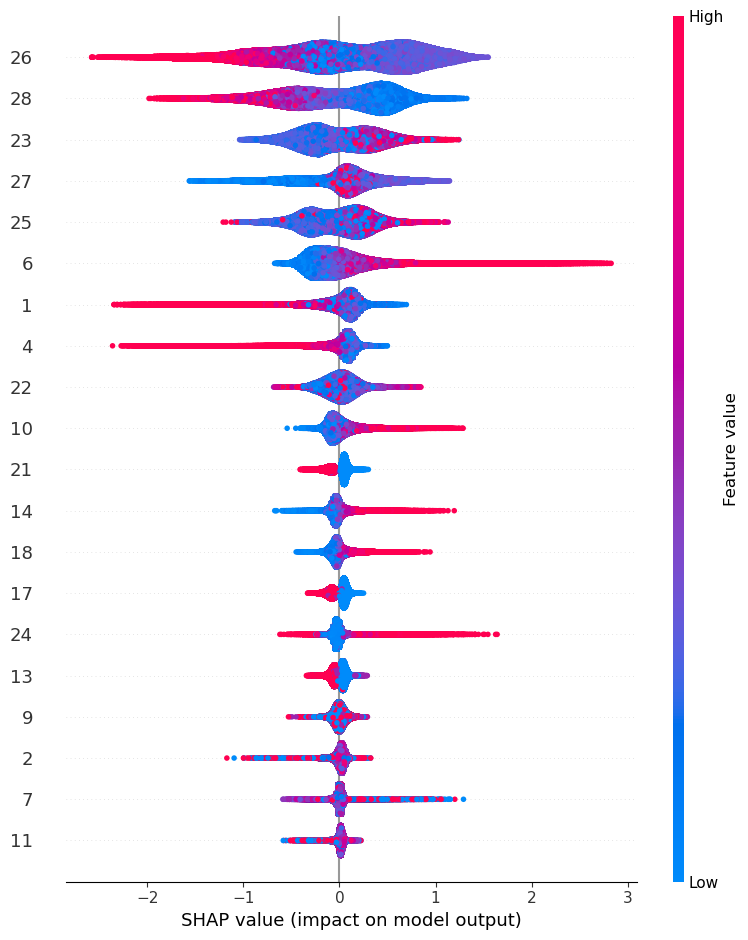

In [75]:
import shap
time_cpu_shap = ['CPU']
start = timeit.default_timer()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
stop = timeit.default_timer()
time_cpu_shap.append(stop-start)
shap.summary_plot(shap_values, X_test,show=False)

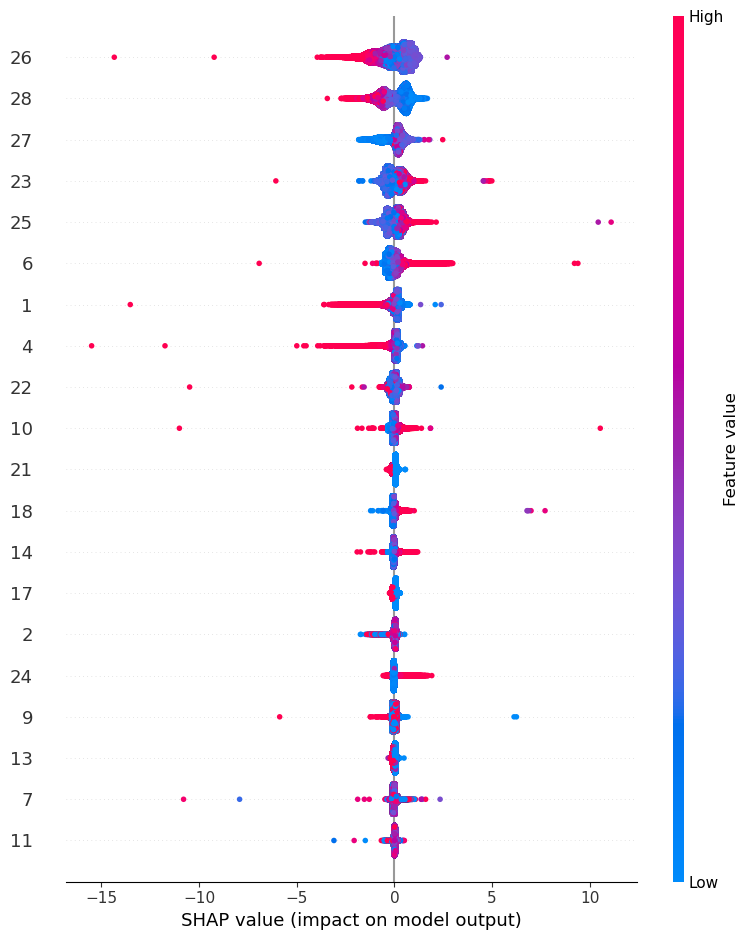

In [76]:
import shap
start = timeit.default_timer()
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)
stop = timeit.default_timer()
time_cpu_shap.append(stop-start)
shap.summary_plot(shap_values, X_test,show=False)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


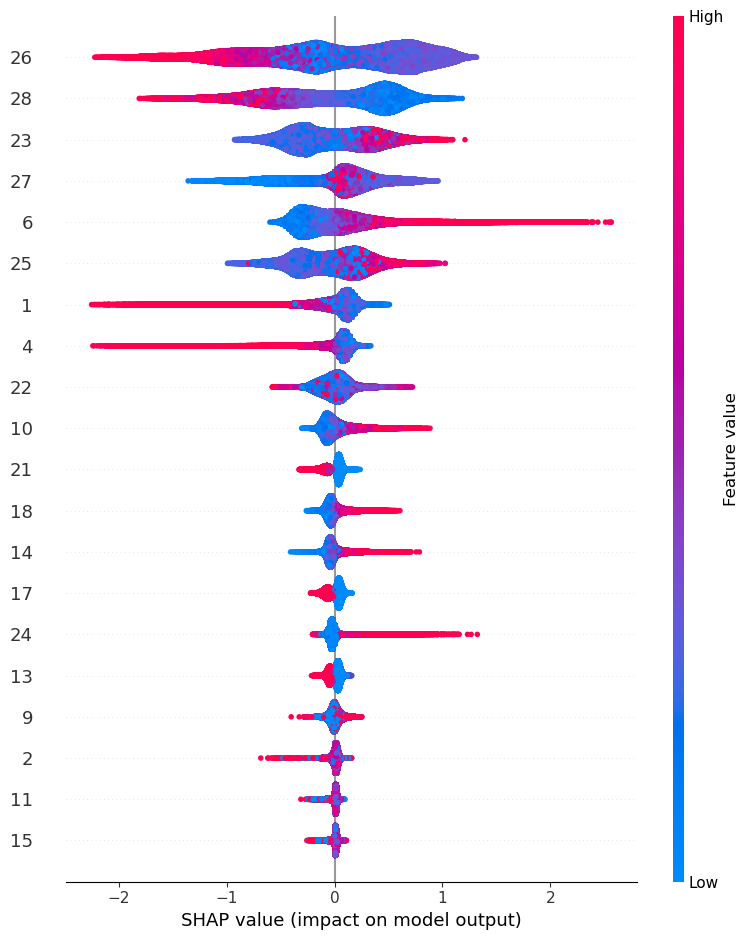

In [77]:
import shap
start = timeit.default_timer()
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)
stop = timeit.default_timer()
time_cpu_shap.append(stop-start)
shap.summary_plot(shap_values[1], X_test,show=False)

In [79]:
time_cpu_shap

['CPU', 4620.933531924995, 32.60655866500747, 113.2479361500009]

## SHAP using GPU

I have tried to run SHAP on my GPU, but I'm encountering problems with my CUDA version, and currently, I believe it's a common issue with my modern GPU. [BUG: No GPU Support for Modern CUDA](https://github.com/shap/shap/issues/3251).

But you can try to run this code, after installing `nvcc`. See [GPUTree](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/GPUTree.html)

In [ ]:
import shap
time_gpu_shap = ['GPU']
start = timeit.default_timer()
explainer = shap.explainers.GPUTree(xgb_model)
shap_values = explainer.shap_values(X_test)
stop = timeit.default_timer()
time_gpu_shap.append(stop-start)
shap.summary_plot(shap_values, X_test,show=False)

In [ ]:
start = timeit.default_timer()
explainer = shap.explainers.GPUTree(cat_model)
shap_values = explainer.shap_values(X_test)
stop = timeit.default_timer()
time_gpu_shap.append(stop-start)
shap.summary_plot(shap_values, X_test,show=False)

In [ ]:
start = timeit.default_timer()
explainer = shap.explainers.GPUTree(lgbm_model)
shap_values = explainer.shap_values(X_test)
stop = timeit.default_timer()
time_gpu_shap.append(stop-start)
shap.summary_plot(shap_values[1], X_test,show=False)

# Bibliography
You can find all files in [this repository](https://github.com/joaomh/xgboost-catboost-lgbm)

References, and, of course, you can access the documentation for each algorithm. 


[1] - [Schapire, Robert E(1999). A Short Introduction to Boosting](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf)

[2] - [HASTIE, T.; TIBSHIRANI, R.; FRIEDMAN, J. (2009). The Elements of Statistical Learning](https://hastie.su.domains/Papers/ESLII.pdf)

[3] - [Jerome H. Friedman (2001). GREEDY FUNCTION APPROXIMATION:A GRADIENT BOOSTING MACHINE](https://jerryfriedman.su.domains/ftp/trebst.pdf)

[4] - [Tianqi Chen, Carlos Guestrin (2016).XGBoost: {A} Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754)

[5] - [Anna Veronika Dorogush, Andrey Gulin, Gleb Gusev, Nikita Kazeev, Liudmila Ostroumova Prokhorenkova, Aleksandr Vorobev (2017).CatBoost: unbiased boosting with categorical features](https://arxiv.org/abs/1706.09516)

[6] - [Ke, Guolin and Meng, Qi and Finley, Thomas and Wang, Taifeng and Chen, Wei and Ma, Weidong and Ye, Qiwei and Liu, Tie-Yan (2017).Lightgbm: A highly efficient gradient boosting decision tree](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

[7] - [Anna Veronika Dorogush: Mastering gradient boosting with CatBoost](https://www.youtube.com/watch?v=usdEWSDisS0)

[8] - [Pedro Tabacof Unlocking the Power of Gradient-Boosted Trees](https://www.youtube.com/watch?v=qGsHlvE8KZM)

[9] - [Pinheiro, J., & Becker, M.. (2023). Um estudo sobre algoritmos de Boosting e a otimização de hiperparâmetros utilizando optuna.](https://bdta.abcd.usp.br/item/003122385)
